## Final Project Submission

* Student name: Laura Lewis
* Student pace: full time
* Scheduled project review date/time: 17 May 2019, 3pm BST
* Instructor name: Joe San Pietro
* Blog post URL: part 1 (cleaning and pre-processing): https://towardsdatascience.com/predicting-airbnb-prices-with-deep-learning-part-1-how-to-clean-up-airbnb-data-a5d58e299f6c?source=friends_link&sk=0ad5a63e68210846c65f231826921a00
***

# Table of contents

[1. Introduction and project aims](#Introduction-and-project-aims)

[2. The dataset](#The-dataset)

[3. Cleaning and pre-processing](#Cleaning-and-pre-processing)

[4. Exploratory data analysis](#Exploratory-data-analysis)
   - [Time series](#Time-series)
   - [Numerical features](#Numerical-features)
   - [Categorical features](#Categorical-features)
   - [Boolean (true or false) features](#Boolean-(true-or-false)-features)

[5. Preparing the data for modeling](#Preparing-the-data-for-modeling)

[6. Building a neural network](#Building-a-neural-network)

[7. Conclusions and recommendations](#Conclusions-and-recommendations)

***

# Introduction and project aims

Airbnb is a home-sharing platform that allows home-owners and renters ('hosts') to put their properties ('listings') online, so that guests can pay to stay in them. Hosts are expected to set their own prices for their listings. Although Airbnb and other sites provide some general guidance, there are currently no free services which help hosts price their properties. Paid third party pricing software is available, but generally you are required to put in your own expected average price ('base price'), and the algorithm will vary the daily price around that base price on each day depending on day of the week, seasonality, how far away the date is, and other factors.

Airbnb pricing is important to get right, particularly in big cities like London where there is lots of competition and even small differences in prices can make the difference between optimum occupancy and high earnings, or being priced out of the market. It is also a difficult thing to do correctly, in order to balance the price with occupancy (which varies inversely with price) in order to maximise revenue.

This project aims to use machine learning and deep learning to predict the base price for properties in London, and also to explore Airbnb listing data, in order to help Airbnb hosts maximise their earnings.

Additional context: I previously worked for a year and a half at an Airbnb property management company, as head of the team responsible for pricing, revenue and analysis. Decisions made during the course of this project are therefore informed by domain expertise in this industry.

***

# The dataset

The dataset used for this project comes from [Insideairbnb.com](https://insideairbnb.com/), an anti-Airbnb lobby group that scrapes Airbnb listings, reviews and calendar data for multiple cities around the world. The dataset was scraped on 9 April 2019 and contains information on all London Airbnb listings that were live on the site on that date. A GeoJSON file of London borough boundaries was also downloaded from the same site.

The data is quite messy, and has some limitations. The major one is that it only includes the advertised price (sometimes called the 'sticker' price). The sticker price is the overall nightly price that is advertised to potential guests, rather than the actual average amount paid per night by previous guests. The advertised prices can be set to any arbitrary amount by the host, and hosts that are less experienced with Airbnb will often set these to very low (e.g. £0) or very high (e.g. £10,000) amounts.

Nevertheless, this dataset can be used as a proof of concept. A more accurate version could be built using data on the actual average nightly rates paid, e.g. from sites like [AirDNA](https://www.airdna.co/) that sell higher quality Airbnb data.

***

# Cleaning and pre-processing

### Importing the libraries and data

In [2]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [99]:
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose

%tensorflow_version 1.5

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.5`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [100]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [101]:
raw_df = pd.read_csv('/content/drive/My Drive/data/london.csv',low_memory=False)
print(raw_df.info(verbose=False))
pd.set_option('display.max_rows', 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85068 entries, 0 to 85067
Columns: 106 entries, id to reviews_per_month
dtypes: float64(23), int64(21), object(62)
memory usage: 68.8+ MB
None


In [102]:
raw_df.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20191105115249,2019-11-06,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,"Amenities Bedding: 1 Double bed, 1 living room...",Unlike most rental apartments out there my fla...,family,Not even 10 minutes by metro from Victoria Sta...,No Smoking (very strict) Check-in time is afte...,Tons of buses (24hrs) go into central London f...,Guest will have access to the entire apartment,No interaction with guests as you book the ent...,No Smoking (very strict) No pets are allowed i...,NaN,NaN,https://a0.muscache.com/im/pictures/1d720898-c...,NaN,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/47773...,https://a0.muscache.com/im/pictures/user/47773...,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Brixton,Lambeth,...,$20.00,3,180,3,3,180,180,3.0,180.0,4 days ago,t,17,41,61,336,2019-11-06,185,2,2010-03-21,2019-09-15,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,f,strict_14_with_grace_period,f,t,2,2,0,0,1.58
1,38151,https://www.airbnb.com/rooms/38151,20191105115249,2019-11-06,Double room/ lounge,NaN,"Comfortable, large double room /lounge area av...","Comfortable, large double room /lounge area av...",none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/214176/451...,NaN,163634,https://www.airbnb.com/users/show/163634,Lisa,2010-07-11,GB,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,Crystal Palace,1.0,1.0,['phone'],f,f,"Upper Norwood, Surrey, United Kingdom",LB of Croydon,Croydon,...,$0.00,1,730,1,1,730,730,1.0,730.0,never,t,30,60,90,365,2019-11-06,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,flexible,f,f,1,0,1,0,NaN
2,13913,https://www.airbnb.com/rooms/13913,20191105115249,2019-11-06,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,For art lovers I can give guest my Tate Member...,The flat only a 10 minute walk to Finsbury Par...,Guest will have access to the self catering ki...,I like to have little chats with my guest over...,I'm an artist and have my artwork up on the wa...,NaN,NaN,https://a0.muscache.com/im/pictures/ffb507b7-9...

### Dropping initial columns

NLP will not be used in the creation of an initial model (although they could be used to augment the model later, e.g. through sentiment analysis). Therefore, free text columns will be dropped for now, as will other columns which are not useful for predicting price (e.g. url, host name and other host-related features that are unrelated to the property).

In [0]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

['host_acceptance_rate', 'neighbourhood_group_cleansed', 'state', 'zipcode', 'square_feet', 'weekly_price', 'monthly_price', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'license', 'jurisdiction_names', 'reviews_per_month']


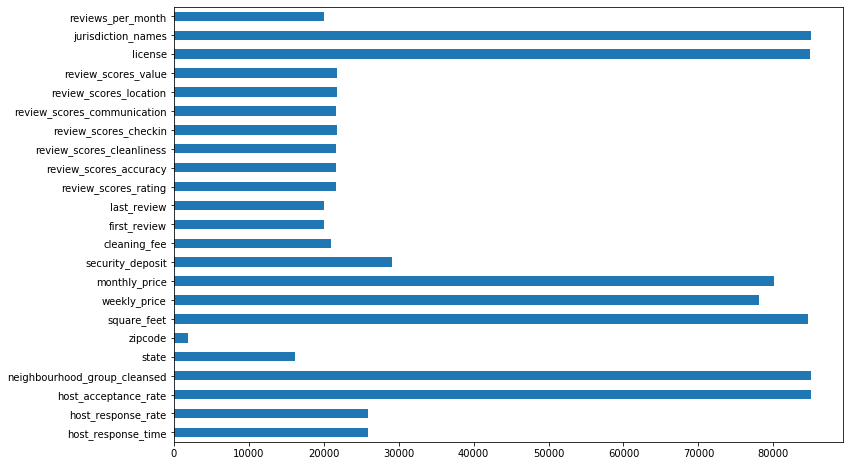

In [104]:
df.isna().sum()[df.isna().sum()>1000].plot(kind='barh',figsize=(12,8))
missing_val_columns_to_drop = list(df.isna().sum()[df.isna().sum()>1000].index)
missing_val_columns_to_drop.remove('host_response_time') #keep host_response_time
missing_val_columns_to_drop.remove('host_response_rate') #keep host_response_time
missing_val_columns_to_drop.remove('cleaning_fee') #keep host_response_time
missing_val_columns_to_drop.remove('security_deposit') #keep host_response_time
missing_val_columns_to_drop.remove('first_review') #keep host_response_time
missing_val_columns_to_drop.remove('review_scores_rating') #keep host_response_time
missing_val_columns_to_drop.remove('review_scores_accuracy') #keep host_response_time
missing_val_columns_to_drop.remove('review_scores_cleanliness') #keep host_response_time
missing_val_columns_to_drop.remove('review_scores_value') #keep host_response_time
missing_val_columns_to_drop.remove('last_review') #keep host_response_time
print(missing_val_columns_to_drop)

Other columns can be dropped because they contain a majority of null entries.

In [0]:
df.drop(missing_val_columns_to_drop, axis=1, inplace=True)
df.set_index('id', inplace=True) # The id will be used as the index, as this could be useful in future e.g. if a separate dataset containing reviews for each property is linked to this one

host_listings_count and host_total_listings_count are the same in all but 248 cases. These cases are those where the value is NaN. Therefore one of these columns can be dropped. Other columns which split these into type of property will also be dropped, as they will be highly correlated (one will be the total of the others).

In [106]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:5]

12


,experiences_offered,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4749800,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"London, United Kingdom",LB of Islington,Islington,London,London,"London, United Kingdom",GB,United Kingdom,51.55072,-0.11855,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Buzzer/wireless int...",$60.00,NaN,$20.00,1,$0.00,2,1125,2,2,1125,1125,2.0,1125.0,4 days ago,t,16,28,46,136,222,42,2015-01-27,2019-10-19,90.0,9.0,8.0,9.0,f,t,f,moderate,f,f,1,0,1,0
5811550,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"London, United Kingdom",Bethnal Green,Tower Hamlets,London,London,"London, United Kingdom",GB,United Kingdom,51.52637,-0.06732,t,House,Private room,1,1.5,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,""Smoking allowed"",""Hot ...",$50.00,NaN,NaN,1,$0.00,1,1125,1,1,1125,1125,1.0,1125.0,52 months ago,t,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f,1,0,1,0
6985409,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Beckenham, United Kingdom",LB of Bromley,Bromley,Beckenham,London,"Beckenham, United Kingdom",GB,United Kingdom,51.41201,-0.02034,f,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free parking on pre...",$30.00,NaN,$4.00,1,$0.00,1,1125,1,1,1125,1125,1.0,1125.0,52 months ago,t,28,58,88,88,0,0,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f,1,0,1,0
7007873,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"London, United Kingdom",City of Westminster,Westminster,London,London,"London, United Kingdom",GB,United Kingdom,51.49452,-0.13415,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,""Hot tub"",""Buzzer/wirel...",$35.00,NaN,NaN,1,$0.00,8,1125,8,8,1125,1125,8.0,1125.0,50 months ago,t,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,strict_14_with_grace_period,f,f,1,0,1,0
7595146,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"London, United Kingdom",LB of Tower Hamlets,Tower Hamlets,London,London,"London, United Kingdom",GB,United Kingdom,51.48728,-0.01216,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Pool,Kitchen,""Free parking on p...",$30.00,NaN,NaN,1,$0.00,1,1125,1,1,1125,1125,1.0,1125.0,52 months ago,t,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f,1,0,1,0


In [0]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

There are multiple columns for property location, including an attempt by the site that originally scraped the data to clean up the neighbourhood locations. Some of these columns can be dropped. Because all of the listings are in London, columns relating to city and country can be dropped. One columns for area (borough) will be kept - 'neighboorhood_cleansed'. Latitude and longitude will be saved in a dataframe for later use (see modelling section below).

In [0]:
lat_long = df[['latitude', 'longitude']]

In [0]:
df.drop(['latitude', 'longitude', 'street', 'neighbourhood', 'city', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

There are multiple columns for minimum and maximum night stays, but the two main ones will be used as there are few differences between e.g. minimum_nights and minimum_minimum_nights. The latter presumably refers to the fact that min/max night stays can vary over the year. The default (i.e. most frequently applied) min/max night stay values will be used instead.

In [110]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)

4800

In [0]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

Checking whether boolean and categorical features contain sufficient numbers of instances in each category to make them worth including:

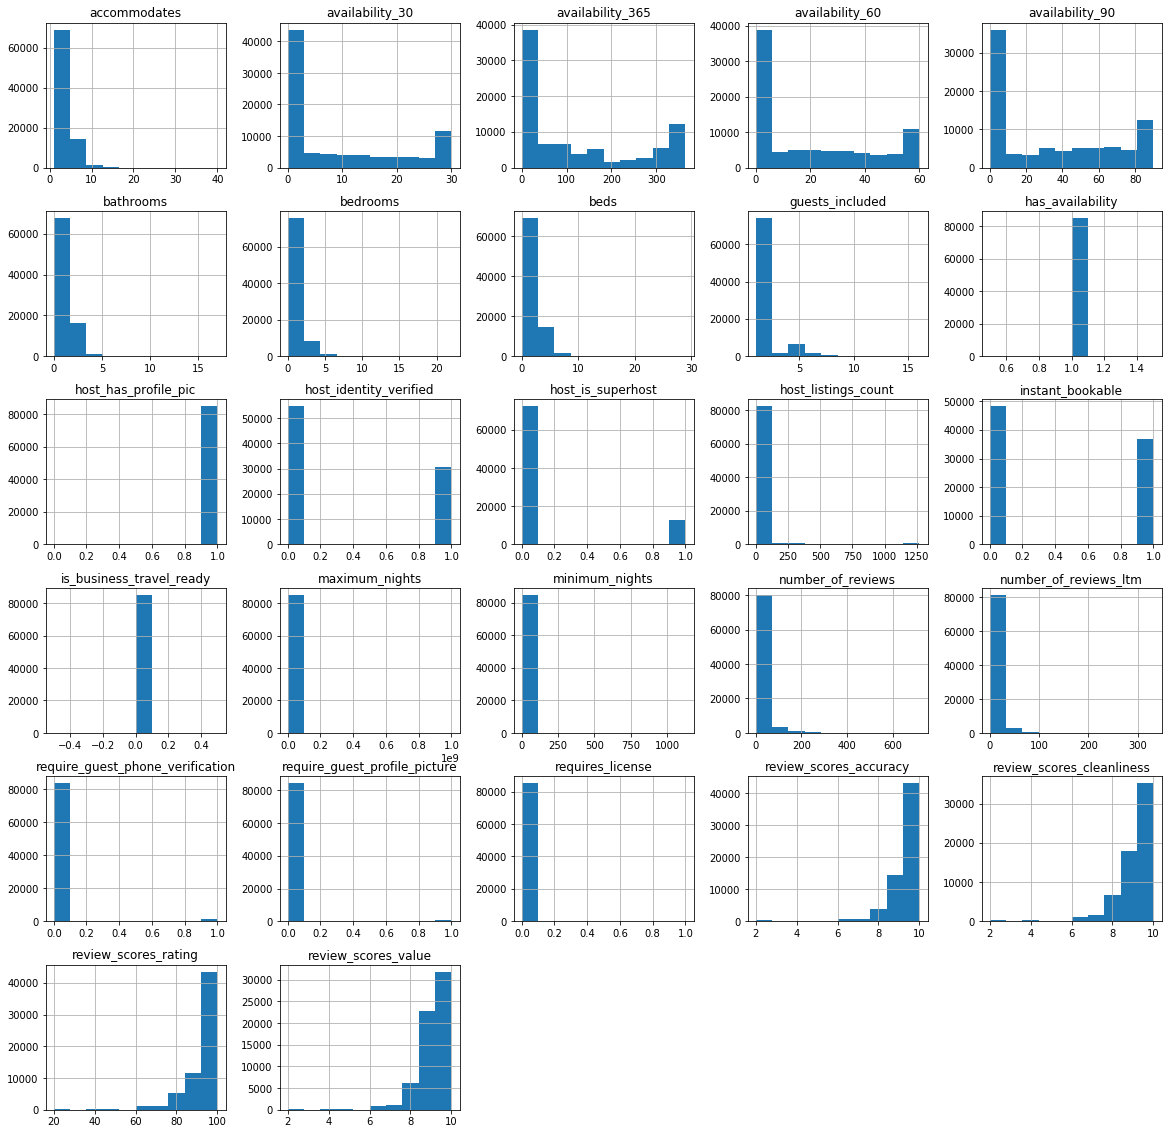

In [112]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

From the above, it can be seen that several columns only contain one category and can be dropped:

In [0]:
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)

### Description of each column:
- experiences_offered - slightly unclear as it does not appear to directly relate to Airbnb Experiences, but this seems to be the main recommended category of travel type, e.g. business
- host_since - date that the host first joined Airbnb
- host_response_time - average amount of time the host takes to reply to messages
- host_response_rate - proportion of messages that the host replies to
- host_is_superhost - whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb
- host_listings_count - how many listings the host has in total
- host_identity_verified - whether or not the host has been verified with id
- neighbourhood_cleansed - the London borough the property is in
- property_type - type of property, e.g. house or flat
- room_type - type of listing, e.g. entire home, private room or shared room
- accommodates - how many people the property accommodates
- bathrooms - number of bathrooms
- bedrooms - number of bedrooms
- beds - number of beds
- bed_type - type of bed, e.g. real bed or sofa-bed
- amenities - list of amenities
- price - nightly advertised price (the target variable)
- security_deposit - the amount required as a security deposit
- cleaning_fee - the amount of the cleaning fee (a fixed amount paid per booking)
- guests_included - the number of guests included in the booking fee
- extra_people - the price per additional guest above the guests_included price
- minimum_nights - the minimum length of stay
- maximum_nights - the maximum length of stay
- calendar_updated - when the host last updated the calendar
- availability_30 - how many nights are available to be booked in the next 30 days
- availability_60 - how many nights are available to be booked in the next 60 days
- availability_90 - how many nights are available to be booked in the next 90 days
- availability_365 - how many nights are available to be booked in the next 365 days
- number_of_reviews - the number of reviews left for the property
- number_of_reviews_ltm - the number of reviews left for the property in the last twelve months
- first_review - the date of the first review
- last_review - the date of the most recent review
- review_scores_rating - guests can score properties overall from 1 to 5 stars
- review_scores_accuracy - guests can score the accuracy of a property's description from 1 to 5 stars
- review_scores_cleanliness - guests can score a property's cleanliness from 1 to 5 stars
- review_scores_checkin - guests can score their check-in from 1 to 5 stars
- review_scores_communication - guests can score a host's communication from 1 to 5 stars
- review_scores_location - guests can score a property's location from 1 to 5 stars
- review_scores_value - guests can score a booking's value for money from 1 to 5 stars
- instant_bookable - whether or not the property can be instant booked (i.e. booked straight away, without having to message the host first and wait to be accepted)
- cancellation_policy - the type of cancellation policy, e.g. strict or moderate
- reviews_per_month - calculated field of the average number of reviews left by guest each month

### Cleaning individual columns

**experiences_offered**

Most listings offer no experiences so this feature can be dropped.

In [114]:
df.experiences_offered.value_counts()

none        83388
business      582
family        479
social        411
romantic      208
Name: experiences_offered, dtype: int64

In [0]:
df.drop('experiences_offered', axis=1, inplace=True)

**host_since**

This is a datetime column, and will be converted into a measure of the number of days that a host has been on the platform, measured from the date that the data was scraped (9 April 2019). The original column will be left in initially for EDA, and dropped later.

In [116]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (datetime(2019, 4, 9) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1241.0
Median days as host: 1253.0


**host_response_time**

About a third of rows don't have a value for host_response_time, and the majority of these have also not yet been reviewed. Therefore this section of the dataset consists primarily of properties which have not yet had a completed stay (most likely properties which have not yet had a booking, although may also include properties that have a booking currently occuring). Although this is a considerable proportion of the dataset, these listings will be retained in the data because they are still legitimate properties with advertised prices, and are still part of the comparative market when considering the price for which to advertise your Airbnb listing. However, if the dataset being used had the actual average price paid as its target, it would be necessary to drop these rows because they would not have a value, as they have not yet been booked.

It is worth noting, however, that this group of listings probably also contains a large number of 'inactive' listings. These are properties which have been speculatively listed on Airbnb but either have their calendars closed (so no stays can be booked), or have prices which are notably higher than other properties in their area. The latter occurs in some cases when people who regularly live in a property put their property on Airbnb at a high price just to see if anyone is willing to book at that price (some Airbnb listings are indeed booked at very high prices). Then if their property is booked, they will decamp to a cheaper hotel for those dates, and pocket the difference in price.

Because host_response_time is unknown for so many listings, it will be retained as its own category, 'unknown'.

In [117]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
len(df[df.loc[ :,['host_response_time ', 'first_review'] ].isnull().sum(axis=1) == 2])

Null values: 25900
Proportion: 30.4%


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


20006

In [118]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

within an hour        0.440248
unknown               0.304462
within a few hours    0.143062
within a day          0.092479
a few days or more    0.019749
Name: host_response_time, dtype: float64

In [119]:
df.host_response_time.value_counts(normalize=True)

within an hour        0.440248
unknown               0.304462
within a few hours    0.143062
within a day          0.092479
a few days or more    0.019749
Name: host_response_time, dtype: float64

**host_response_rate**

A similar story is true for host_response_rate, with about a third of values being null. This will also be kept as its own category, after grouping other values into meaningful groups (i.e. transforming this into a categorical feature, rather than a numerical one). Because about 70% of hosts respond 100% of the time, this will be kept as its own category, and other values will be grouped into bins.

In [120]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 25900
Proportion: 30.4%


In [121]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 93.0
Median host response rate: 100.0
Proportion of 100% host response rates: 67.5%


In [122]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       39938
unknown    25900
50-89%      9194
90-99%      7675
0-49%       2361
Name: host_response_rate, dtype: int64

**host_is_superhost**

There are 248 rows lacking values for each of five different host-related features. These rows will be dropped.

In [123]:
# Number of rows without a value for multiple host-related columns
len(df[df.loc[ :,['host_since ', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 'host_identity_verified'] ].isnull().sum(axis=1) == 5])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


12

In [0]:
df.dropna(subset=['host_since'], inplace=True)

**property_type**

Some cleaning of property types is required as there are a large number of categories with only a few listings. The categories 'apartment', 'house' and 'other' will be used, as most properties can be classified as either apartments or houses.

In [125]:
df.property_type.value_counts()

Apartment                 56257
House                     17876
Condominium                2984
Townhouse                  2982
Serviced apartment         1489
Loft                        745
Bed and breakfast           645
Guest suite                 366
Guesthouse                  305
Boutique hotel              235
Other                       199
Hostel                      187
Hotel                       162
Bungalow                    138
Cottage                      92
Tiny house                   65
Boat                         61
Villa                        59
Aparthotel                   49
Houseboat                    35
Cabin                        20
Camper/RV                    17
Earth house                  16
Chalet                       12
Hut                          11
Barn                          8
Casa particular (Cuba)        7
Farm stay                     6
Yurt                          5
Tent                          4
Treehouse                     3
Dome hou

In [0]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

**bathrooms, bedrooms and beds**

Missing values will be replaced with the median (to avoid strange fractions).

In [0]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

**bed_type**

Most listings have the same bed type so this feature can be dropped.

In [128]:
df.bed_type.value_counts()

Real Bed         84383
Pull-out Sofa      397
Futon              172
Couch               66
Airbed              38
Name: bed_type, dtype: int64

In [0]:
df.drop('bed_type', axis=1, inplace=True)

**amenities**

Amenities is a list of additional features in the property, e.g. whether it has a TV or parking. Examples are below:

In [130]:
# Example of amenities listed
df.amenities[:1].values

array(['{TV,"Cable TV",Internet,Wifi,Kitchen,"Paid parking off premises","Buzzer/wireless intercom",Heating,"Family/kid friendly",Washer,"Smoke detector","Carbon monoxide detector",Essentials,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in",Lockbox,"Pack ’n Play/travel crib","Hot water","Long term stays allowed"}'],
      dtype=object)

In [131]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'Alfresco bathtub',
 'Amazon Echo',
 'Apple TV',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Balcony',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beach view',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Body soap',
 'Breakfast',
 'Breakfast bar',
 'Breakfast table',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Ceiling fans',
 'Ceiling hoist',
 'Central air conditioning',
 'Changing table',
 'Charcoal barbeque',
 "Chef's kitchen",
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'DVD player',
 'Day bed',
 'Dining area',
 'Dining table',
 'Disabled parking spot',
 'Dishes and silverware'

In the list above, some amenities are more important than others (e.g. a balcony is more likely to increase price than a fax machine), and some are likely to be fairly uncommon (e.g. 'Electric profiling bed'). Based on previous experience working in the Airbnb property management industry, and research into which amenities are considered by guests to be more important, a selection of the more important amenities will be extracted. These will be further investigated in the EDA section. For example, if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.

The amenities chosen are (slashes indicate separate categories that can be combined):
- 24-hour check-in
- Air conditioning/central air conditioning
- Amazon Echo/Apple TV/DVD player/game console/Netflix/projector and screen/smart TV (i.e. non-basic electronics)
- BBQ grill/fire pit/propane barbeque
- Balcony/patio or balcony
- Beach view/beachfront/lake access/mountain view/ski-in ski-out/waterfront (i.e. great location/views)
- Bed linens
- Breakfast
- Cable TV/TV
- Coffee maker/espresso machine
- Cooking basics
- Dishwasher/Dryer/Washer/Washer and dryer
- Elevator
- Exercise equipment/gym/private gym/shared gym
- Family/kid friendly, or anything containing 'children'
- Free parking on premises/free street parking/outdoor parking/paid parking off premises/paid parking on premises
- Garden or backyard/outdoor seating/sun loungers/terrace
- Host greets you
- Hot tub/jetted tub/private hot tub/sauna/shared hot tub/pool/private pool/shared pool
- Internet/pocket wifi/wifi
- Long term stays allowed
- Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s)
- Private entrance
- Safe/security system
- Self check-in
- Smoking allowed
- Step-free access/wheelchair accessible, or anything containing 'accessible'
- Suitable for events

In [132]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


One way to reduce the number of features (to avoid the curse of dimensionality) is to remove the amenities which add relatively little information, or are relatively unhelpful in differentiating between different listings. Amenity features where either the true or the false category contains fewer than 10% of listings will be removed.

In [133]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,41:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['nature_and_views', 'gym', 'hot_tub_sauna_or_pool', 'secure', 'smoking_allowed', 'accessible', 'event_suitable']


In [134]:
df.columns[40:]

Index(['balcony', 'bed_linen', 'breakfast', 'tv', 'coffee_machine',
       'cooking_basics', 'white_goods', 'elevator', 'child_friendly',
       'parking', 'outdoor_space', 'host_greeting', 'internet',
       'long_term_stays', 'pets_allowed', 'private_entrance', 'self_check_in'],
      dtype='object')

**price**

Price will be converted to an integer - currently it is a string because there is a currency sign.

In [0]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

**security_deposit**

As with price, this will be converted to an integer - currently it is a string because there is a currency sign.

Having a missing value for security deposit is functionally the same as having a security deposit of £0, so missing values will be replaced with 0.

In [136]:
df.security_deposit.isna().sum()

29115

In [0]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')

**cleaning_fee**

As with price, this will be converted to an integer - currently it is a string because there is a currency sign.

As with security deposit, having a missing value for cleaning fee is functionally the same as having a cleaning fee of £0, so missing values will be replaced with 0.

In [138]:
df.cleaning_fee.isna().sum()

20989

In [0]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

**extra_people**

As with price, this will be converted to an integer - currently it is a string because there is a currency sign.

As with security deposit, having a missing value for extra people is functionally the same as having an extra people fee of £0, so missing values will be replaced with 0.

In [0]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

**calendar_updated**

There are 96 unique categories for calendar_updated, and it is not entirely clear what this feature is adding to the model (a host might update their calendar for multiple different reasons). Therefore this column will be dropped.

In [141]:
print("Number of categories:", df.calendar_updated.nunique())
print("\nTop five categories:")
df.calendar_updated.value_counts()[:5]

Number of categories: 103

Top five categories:


today           12689
2 months ago     8011
a week ago       5211
2 weeks ago      5101
yesterday        4077
Name: calendar_updated, dtype: int64

In [0]:
df.drop('calendar_updated', axis=1, inplace=True)

**availability**

There are multiple different measures of availability, which will be highly correlated with each other. Only one will be retained - for 90 days. This is because in London it is illegal to have short-term (e.g. Airbnb) guests paying to stay in your property for more than 90 days each calendar year, so this is the maximum that should theoretically be possible.

In [0]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

**first_review and last_review**

About a quarter of listings have not had a review written for them. This is too large a proportion of the dataset to drop, and dropping the columns would lose a lot of useful information - reviews are very important in people's decisions to book, and therefore price.

This is also too large a proportion of the dataset to simply replace with median/mean values, as this would skew the distribution substantially. Also, the missing values here are not really missing values, as the fact that they are NaNs is meaningful - it tells us that these are new or previously unbooked listings that have not had reviews yet. In order to make the resulting model work able to predict prices for any Airbnb listing, including brand new listings, is is actually beneficial to keep them in. Therefore, these will be kept as an 'unknown' category, and the feature will have to be treated as categorical (and therefore one-hot encoded) rather than numerical.

In [144]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 23.5%
Null values in 'review_scores_rating': 25.4%


In [0]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2019, 4, 9) - df.first_review).astype('timedelta64[D]')

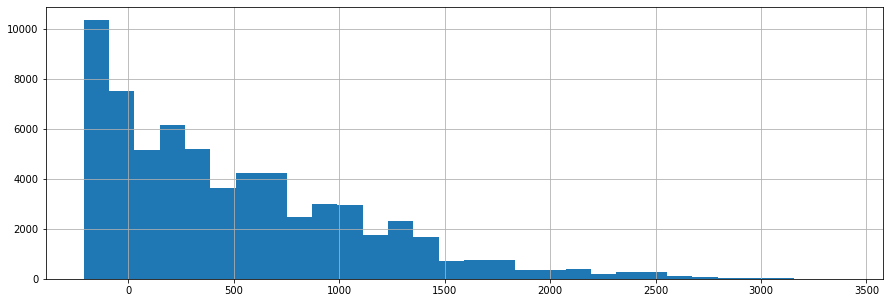

In [146]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [0]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [0]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

The same process will be followed for last_review:

In [0]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2019, 4, 9) - df.last_review).astype('timedelta64[D]')

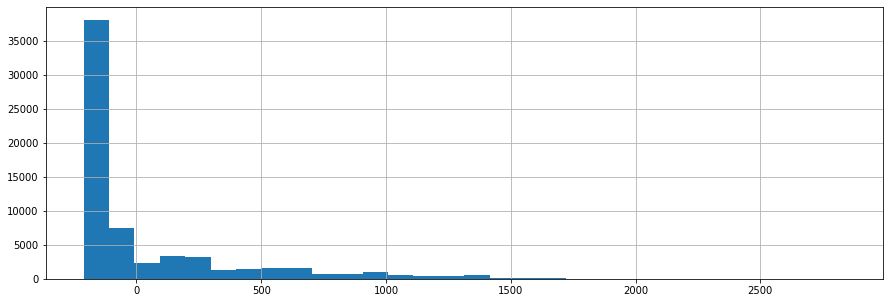

In [150]:
# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [0]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [0]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

**review ratings columns**

As above, listings without reviews will be kept and replaced with 'unknown'. Other ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins. The majority of ratings are 9 or 10 out of 10, as also seen in the value count below. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together (as this is, by Airbnb standards, a 'low' rating).

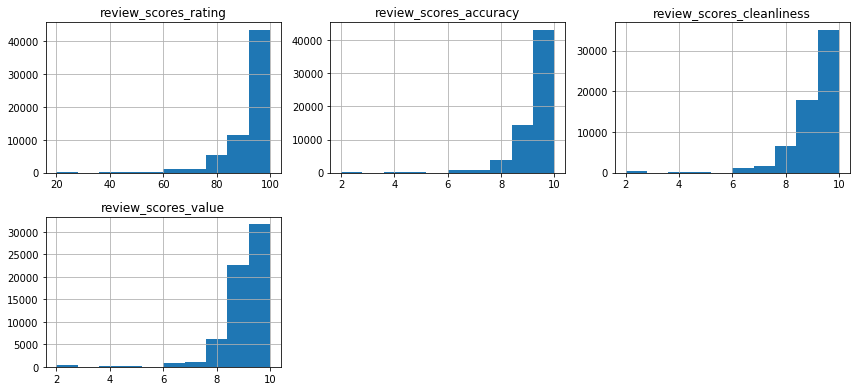

In [153]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [154]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [0]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [0]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

**cancellation_policy**

Some cleaning of cancellation policy types is required, in order to categorise the four very small categories into the three larger categories (e.g. the super strict options are only available to long-term Airbnb hosts, and is invitation only).

In [157]:
df.cancellation_policy.value_counts()

strict_14_with_grace_period    36760
flexible                       27286
moderate                       20021
super_strict_60                  574
super_strict_30                  376
luxury_moderate                   27
strict                             8
luxury_super_strict_95             4
Name: cancellation_policy, dtype: int64

In [0]:
# Replacing categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

**number_of_reviews_ltm and reviews_per_month**

These will be highly correlated with number_of_reviews and so will be dropped.

In [0]:
df.drop(['number_of_reviews_ltm'], axis=1, inplace=True)

***

# Exploratory data analysis

### Time series

*Question: how long have hosts been listing properties on Airbnb in London?*

Answer: the oldest London listing that is currently live on Airbnb was first listed on the site in August 2008. From 2011 onwards, the number of listings started increasing considerably. However, growth in the number of new hosts (of those currently listing on the site) has been decreasing since 2015, when the UK government introduced a law in 2015 making it illegal to let short-term residential properties for more than 90 nights a year.

A high level of seasonality is evident, with notable peaks in the summer when people put properties online to take advantage of the increased number of tourists in the summer holidays.

There is a big peak in the number of hosts joining Airbnb in 2015. This could be a response to the government legislation, as existing hosts may have created new accounts in order to re-list their properties and get around the 90 day limit.

In [160]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 03 September 2008, and the most recent joined on 04 November 2019.


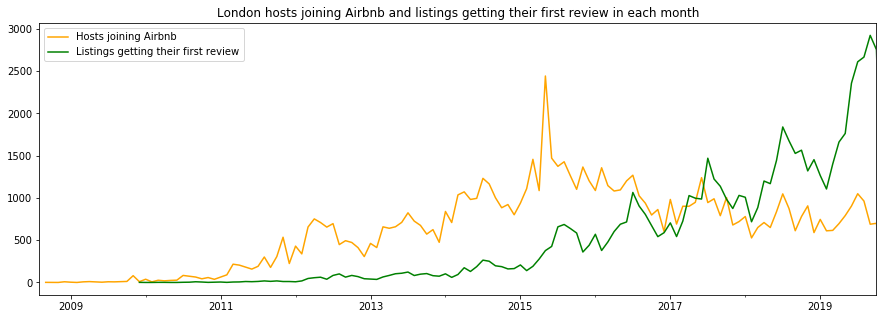

In [167]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='green')
plt.title('London hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2008-08-01', '2019-10-1') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [0]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [0]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

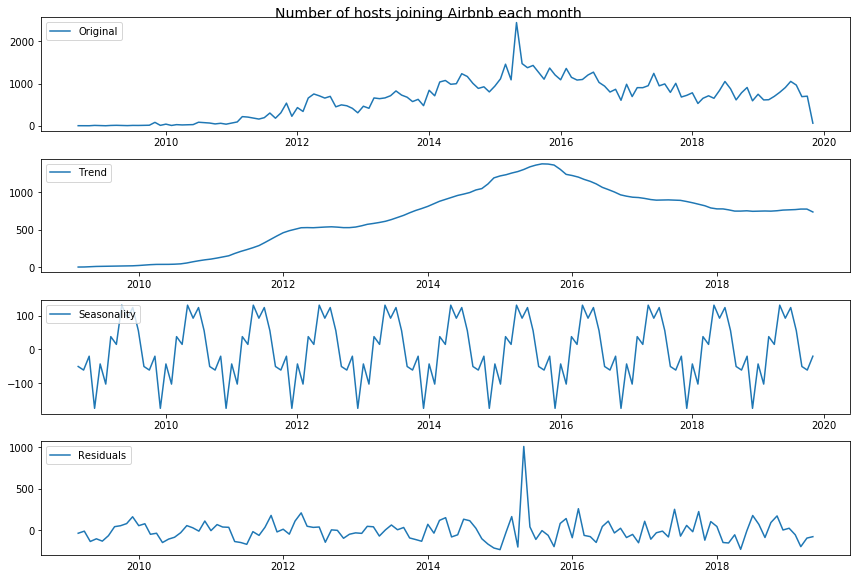

In [170]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

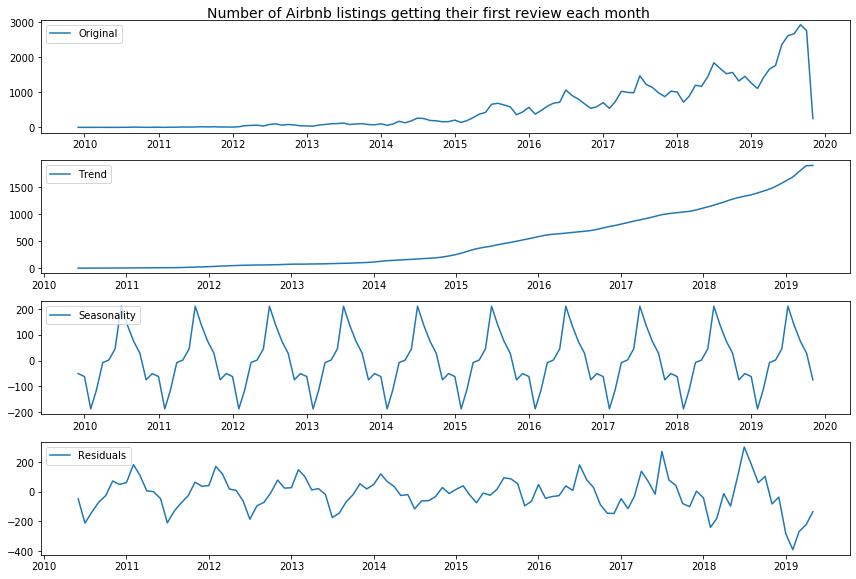

In [70]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

*Question: are the different patterns in the growth in the number of hosts and the number of listings due to hosts increasingly owning multiple properties?*

Answer: there are a number of professional Airbnb management companies which host a large number of listings under a single host profile, particularly from 2013 onwards. The largest manages 1654 listings and is aa management company based in Liverpool operating under the name 'Jp', while the second largest is the management company Veeve, managing 1304 listings.

However, there is no consistent upwards trend in the average number of properties managed by each host.

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


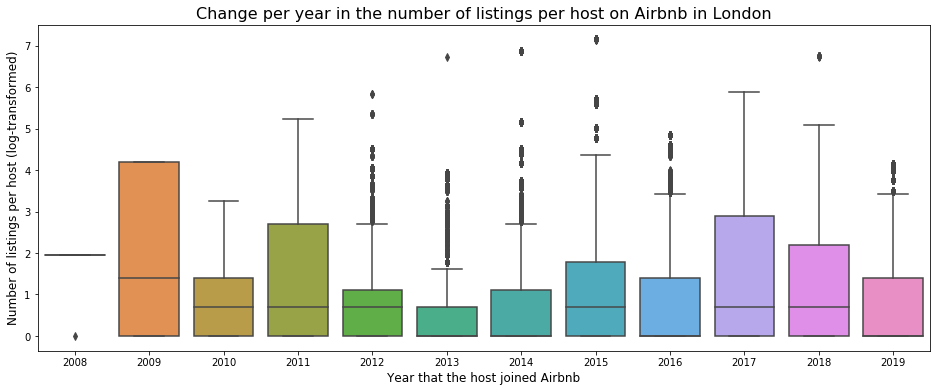

In [171]:
plt.figure(figsize=(16,6))
sns.boxplot(df.host_since.dt.year, np.log(df.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in London', fontsize=16)
plt.show()

In [172]:
print("Average number of listings per host per year on Airbnb in London:")
print(round(df.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per host per year on Airbnb in London:
host_since
2008-01-01     5.56
2009-01-01    29.19
2010-01-01     4.15
2011-01-01    23.24
2012-01-01     6.67
2013-01-01     3.79
2014-01-01    13.78
2015-01-01    93.16
2016-01-01     7.56
2017-01-01    24.11
2018-01-01    14.11
2019-01-01     5.29
Freq: AS-JAN, Name: host_listings_count, dtype: float64


In [173]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
id,,
23588223,2017-06-16,273.0
37911069,2015-11-04,304.0
22376706,2012-11-13,338.0
22758439,2017-10-25,357.0
31066551,2018-09-27,827.0
13229041,2013-02-12,839.0
37582931,2018-03-12,854.0
23077048,2014-02-14,955.0
38276567,2015-04-25,1256.0


*Question: how have prices changed over time?*

Answer: the average price per night for Airbnb listings in London has increased slightly over the last 10 years. In particular, the top end of property prices has increased, resulting in a larger increase in the mean price compared to the median - e.g. the mean price in 2015 was £95.90, whereas the mean price in 2018 (the last complete year of data) was £111.14.

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


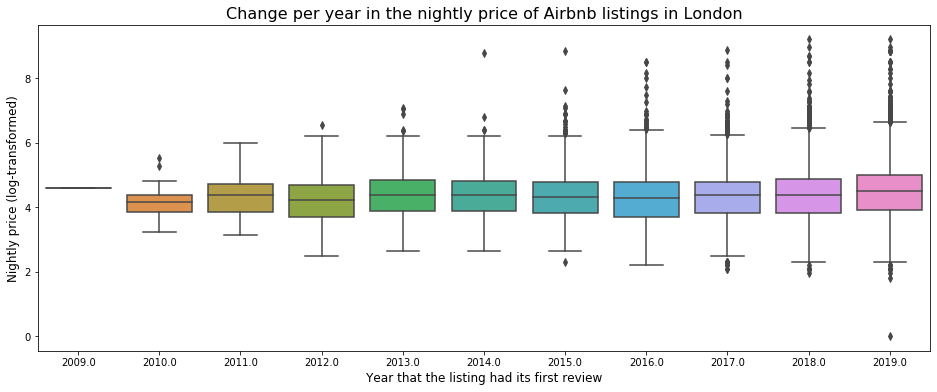

In [174]:
plt.figure(figsize=(16,6))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in London', fontsize=16)
plt.show()

In [175]:
print("Mean nightly price of listings in each year on Airbnb in London:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in London:
first_review
2009-01-01    100.00
2010-01-01     76.50
2011-01-01     93.37
2012-01-01     86.64
2013-01-01    101.49
2014-01-01    102.06
2015-01-01     96.24
2016-01-01     96.75
2017-01-01    101.18
2018-01-01    111.19
2019-01-01    128.40
Name: price, dtype: float64


In [0]:
# Dropping host_since and first_review as they are no longer needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

### Numerical features

In [177]:
df.describe()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,instant_bookable,host_days_active,check_in_24h,air_conditioning,high_end_electronics,bbq,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,outdoor_space,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,self_check_in
count,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,8.505600e+04,85056.000000,85056.000000,85056.00000,85056.000000,5491.0,5006.0,1209.0,2719.0,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000,85056.000000
mean,0.149937,27.449786,0.358082,3.212131,1.306410,1.416408,1.754773,122.344408,129.013379,32.793971,1.626199,7.517318,4.148279,1.388422e+04,33.160953,17.470525,0.43342,1241.202843,1.0,1.0,1.0,1.0,0.122449,0.357964,0.131819,0.691603,0.190345,0.322258,0.867123,0.225393,0.305316,0.398255,0.120086,0.187465,0.963988,0.219350,0.109046,0.237397,0.161858
std,0.357011,143.354443,0.479439,2.032993,0.611246,0.918677,1.280133,220.762732,278.395686,44.246702,1.364530,14.200037,16.682861,3.446247e+06,33.709313,36.784926,0.49555,799.953356,0.0,0.0,0.0,0.0,0.327805,0.479404,0.338296,0.461834,0.392576,0.467344,0.339444,0.417843,0.460544,0.489541,0.325064,0.390286,0.186320,0.413808,0.311699,0.425490,0.368323
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.00000,-209.000000,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,47.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.100000e+01,0.000000,1.000000,0.00000,625.000000,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,0.000000,2.000000,1.000000,1.000000,1.000000,84.000000,0.000000,20.000000,1.000000,0.000000,2.000000,1.125000e+03,25.000000,4.000000,0.00000,1253.000000,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,5.000000,1.000000,4.000000,1.500000,2.000000,2.000000,140.000000,200.000000,50.000000,2.000000,11.000000,3.000000,1.125000e+03,65.000000,17.000000,1.00000,1790.000000,1.0,1.0,1.0,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1270.000000,1.000000,40.000000,17.000000,22.000000,29.000000,12345.000000,17233.000000,1200.000000,16.000000,247.000000,1125.000000,1.000000e+09,90.000000,716.000000,1.00000,3870.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Price**

*Question: what is the overall distribution of prices?*

Answer: nightly advertised prices range from £0 to £13,700. The extreme ends of the range are due to hosts not understanding how to use Airbnb advertised prices (sometimes called 'sticker' prices) correctly. The advertised prices can be set to any arbitrary amount, and these are the prices that show when dates are not entered on the site.

A model is only as good as its data, and unfortunately this model will be predicting advertised prices rather than the prices actually paid. Nevertheless, some cleaning of the particularly unhelpful values will be done. Very small values under £10 will be increased to £10.

There are notable drop-offs in nightly prices at £200 (first graph, orange line), £500 (second graph, orange line) and £1,000 (second graph, red line). Values above £1,000 will  be reduced to £1,000.

In [178]:
print(f"Nightly advertised prices range from £{min(df.price)} to £{max(df.price)}.")

Nightly advertised prices range from £0 to £12345.


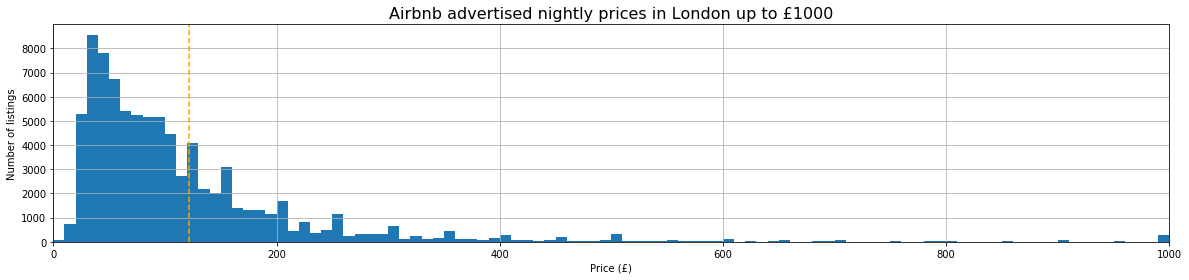

In [179]:
# Distribution of prices from £0 to £1000
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(122, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in London up to £1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

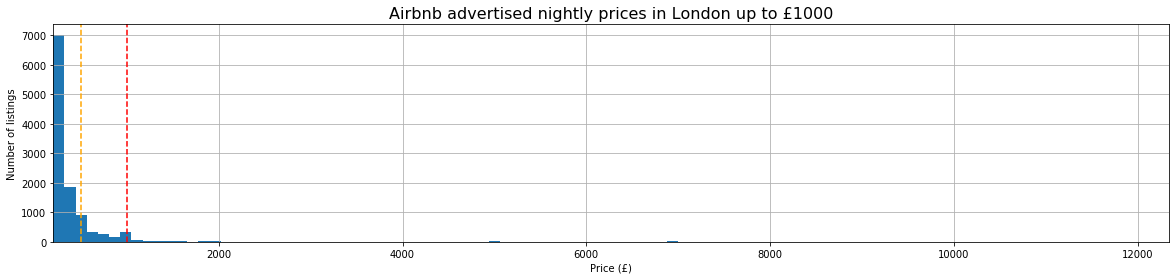

In [180]:
# Distribution of prices from £200 upwards
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(200, max(df.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in London up to £1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

In [0]:
# Replacing values under £10 with £10
df.loc[df.price <= 10, 'price'] = 10

# Replacing values over £1000 with £1000
df.loc[df.price >= 1000, 'price'] = 1000

**Host listings count**

*Question: how many listings do hosts have on average? How many multi-listing hosts are there?*

Answer: the median number of listings that the host of each listing has is 2, i.e. on average (median) each listing is hosted by a host who also manages one other listing. The mean is much higher (30 in total) due to some hosts managing large numbers of listings (as discussed above in the Time Series section). About half of listings are from hosts with one listing, and half are from multi-listing hosts. 

Two difficulties in discerning how many listings hosts have on average are:
- this number is only known on the level of the listing, so hosts with more listings are represented more frequently (e.g a host with 10 listings may be represented up to 10 times in the dataset)
- a host's other listings may not be in London, so some multi-listing hosts may appear multiple times in the dataset, and others may appear only once

In [182]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 2
Mean number of listings per host: 27
44% of listings are from hosts with one listing.


**Number of people accommodated, bathrooms, bedrooms and beds**

*Question: what are the average number of people accommodated, bathrooms, bedrooms and beds in Airbnb listings in London, and how do prices differ?*

Answer: the most common property setup sleeps two people in one bed in one bedroom, with one bathroom. Unsurprisingly, properties that accommodate more people achieve noticeably higher nightly rates, with diminishing returns coming after about 10 people.

Some properties have very high looking values for some features (e.g. one property claims to have 17 bathrooms), but these will be left for now in the interests of time (as double-checking them would be time-consuming).

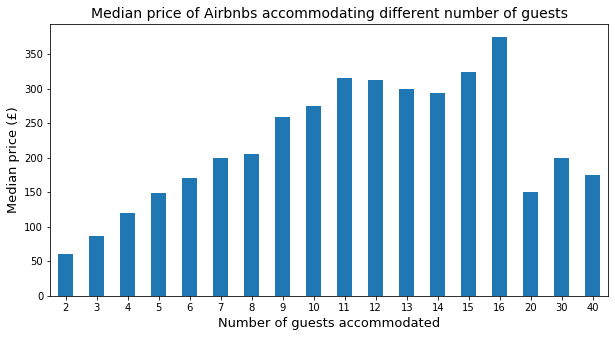

In [183]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (£)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

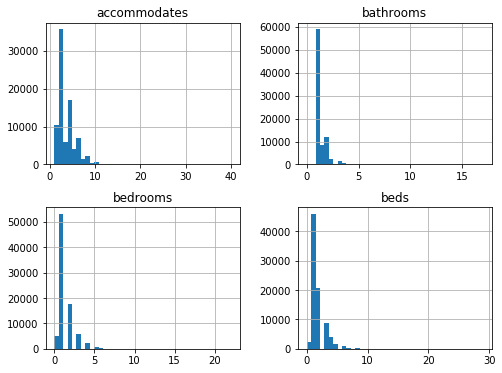

In [184]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6),bins=40);

### Categorical features

Categorical features will be explored and plotted, to gain insights and to determine whether or not they should be included in the final model.

**Neighbourhood**

*Question: which areas have the most Airbnb properties, and which are the most expensive?* 

Answer: Westminster (west central London) has the most Airbnb properties, followed by Tower Hamlets (east central London). Inner London boroughs have significantly more listings than outer London boroughs.

However, the pattern with prices is slightly different. Kensington and Chelsea (to the west of Westminster) is the most expensive area - this is a famously expensive area to live, with some of the highest house prices in the world. Although inner London is generally more expensive than outer London, there are also some more expensive listings spread out to the west of the city along the Thames (which has some very beautiful areas).

There are very few listings in the very centre of London (there is relatively little residential property here), but as a result they are very expensive.

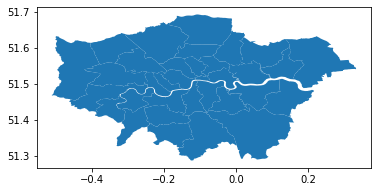

In [185]:
# Renaming the neighbourhood column
df.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

# Importing the London borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('/content/drive/My Drive/data/london.geojson')
map_df.plot()

In [0]:
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df.groupby('borough').size())
borough_df.rename(columns={0: 'number_of_listings'}, inplace=True)
borough_df['median_price'] = df.groupby('borough').price.median().values

# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)

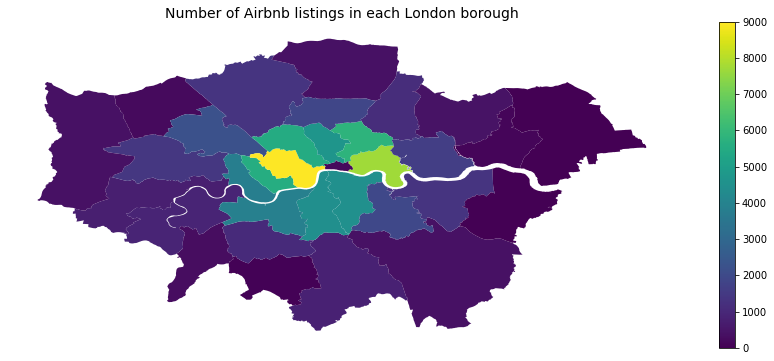

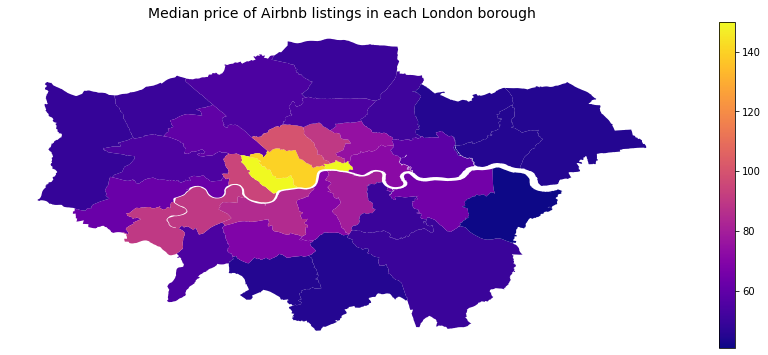

In [189]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='viridis', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each London borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='plasma', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each London borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

**Property and room types**

*Question: what are the most common property and room types?*

Answer: about 70% of properties are apartments. The remainder are houses or more uncommon property types (e.g. 'bed and breakfast' or 'yurt').

About 55% of listings are entire homes (i.e. you are renting the entire property on your own). Most of the remainder are private rooms (i.e. you are renting a bedroom and possibly also a bathroom, but there will be other people in the property). Fewer than 1% are shared rooms (i.e. you are sharing a room with either the property owner or other guests).

In [0]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

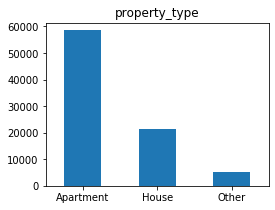

Apartment    0.687676
House        0.249718
Other        0.062606
Name: property_type, dtype: float64


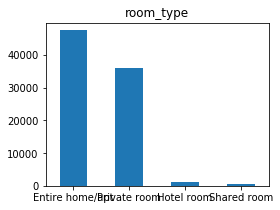

Entire home/apt    0.557774
Private room       0.421757
Hotel room         0.013085
Shared room        0.007383
Name: room_type, dtype: float64


In [191]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(df[col].value_counts(normalize=True))

**Reviews**

*Question: what is the distribution of reviews like?*

Answer: for  every review category, the majority of listings that have had a review have received a 10/10 rating for that category (or 95-100/100 overall) - clearly people love their Airbnbs. Ratings or 8 or below are rare. Guests seem to be most positive about communication, check-ins and accuracy. As noted previously, about a quarter of listings have not yet been reviewed.

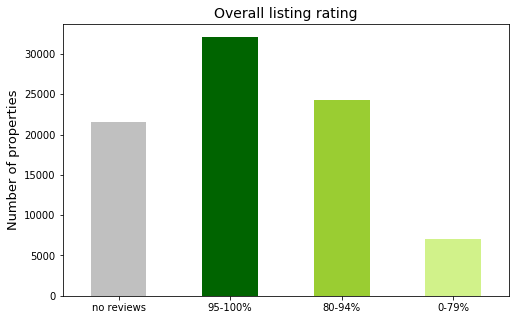

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Overall listing rating', fontsize=14)
df['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['silver', 'darkgreen', 'yellowgreen', '#d1f28a' ], ax=ax)
ax.set_xticklabels(labels=['no reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Number of properties', fontsize=13)
plt.show()

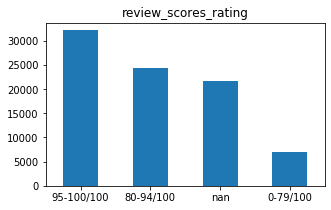

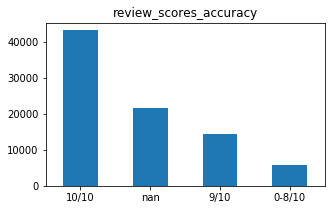

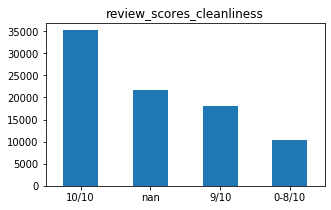

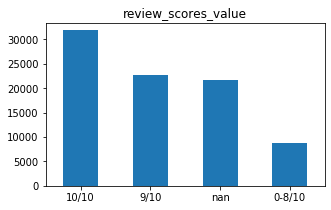

In [193]:
for col in list(df.columns[df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

**First and last reviews**

*Question: how long have listings been on the site, and how many listings have been reviewed recently?*

Answer: the most common time period in which currently live Airbnb listings had their first review is 2-3 years. This means that a lot of listings on the site have been active for at least a couple of years. Relatively few have been active for more than four years, however.

The most common category for the time since a listing received its last review is 2-8 weeks. This means that a lot of listings have been reviewed relatively recently. However, there are still over 10,000 listings which have not had a review for more than a year. The majority of these are probably what are sometimes referred to 'inactive' listings, because although they are technically live on the site, they do not have their calendards open and are not available to book.

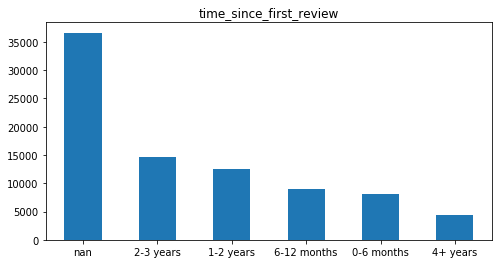

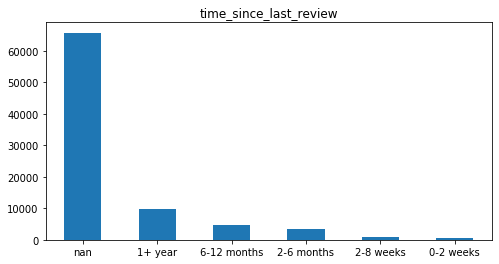

In [194]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

### Boolean (true or false) features

Many features (e.g. for amenities) can be true or false. This section compares the proportions of these features that are true or false (to explore the data and also to ascertain whether the feature is worth retaining), and the median price of each category (to explore the relationship between the category and price).

In [0]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (£)')
    ax2.set_xlabel('')
    
    plt.show()

**Superhosts**

*Question: what proportion of Airbnb hosts are superhosts, and is it worth being one? (a question often asked by hosts)*

Answer: about 15% of hosts are superhosts. However, it does not seem to improve the median price per night of their Airbnb listings, so it is arguable whether or not it is worth it (from a purely financial perspective).

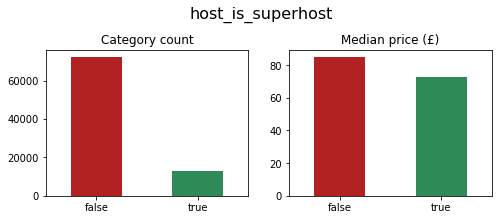

0.0    0.850063
1.0    0.149937
Name: host_is_superhost, dtype: float64


In [196]:
binary_count_and_price_plot('host_is_superhost')
print(df.host_is_superhost.value_counts(normalize=True))

**Host verification**

*Question: how many hosts are verified, and is it worth it? (a question often asked by hosts)*

Answer: only about 35% of hosts are verified (e.g. by providing ID and verifying your phone number and email address), although it is something that hosts often think they are expected to do. Interestingly, however, despite the fact that one might expect the additional trust commanded by verified hosts to result in higher nightly prices, there is no discernable difference between the median nightly prices of listings with verified and unverified hosts. This column will be left in the dataframe, however, in case it has any useful interactions with other features.

In [95]:
df.host_identity_verified.value_counts(normalize=True)

0.0    0.641918
1.0    0.358082
Name: host_identity_verified, dtype: float64

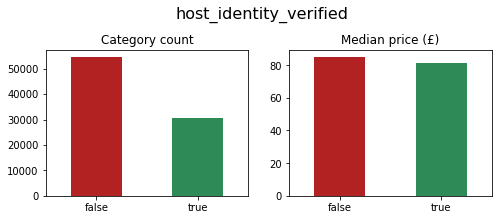

In [96]:
binary_count_and_price_plot('host_identity_verified')

**Instant booking**

*Question: how many properties are instant bookable (i.e. able to be booked without messaging the host first), and is it worth it?*

Answer: only about 40% of properties are instant bookable. However, the added convenience does not seem to have any effect on the median price per night.

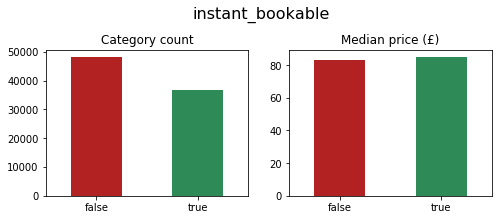

0    0.56658
1    0.43342
Name: instant_bookable, dtype: float64


In [97]:
binary_count_and_price_plot('instant_bookable')
print(df.instant_bookable.value_counts(normalize=True))

**Amenities**

*Question: which amenities are common, and which increase the price of an Airbnb listing?*

Answer: amenities can be split into four main groups:

Uncommon, but properties with it have a higher median price:
- Balcony
- Bed linen
- Coffee machine
- Basic cooking equipment
- Elevator
- Child friendly
- Outdoor space
- Long term stays allowed
- Private entrance
- Safe or security system
- Self check-in

Most properties have it, and properties with it have a higher median price:
- TV
- Washer, dryer and/or dishwasher

Most properties have it, and there is no major difference in price between properties with and without it:
- Internet

Uncommon, and properties with it have a lower median price:
- Breakfast (probably because these are bed & breakfasts and therefore single rooms rather than entire homes)
- Parking (presumably because these are less likely to be central properties)
- Greeted by host (surprisingly!)
- Pets allowed

The takeaway from this is that there are some things that Airbnb hosts can do to try and improve their listing's price, although there is often not a simple causative relationship (e.g. having a parking space might improve your price, but listings with parking spaces are cheaper on average because they are less likely to be in central London, and location is a more important factor than parking space):
- **Make sure you have the necessities that your competitors also have**, e.g. internet, a TV and white goods (a washer, dryer and/or dishwasher).
- If you can, **include some extras to make your property stand out and achieve a higher price**. For example, you could buy a coffee machine, allow self check-in and long-term stays, and make your property child-friendly.
- **Avoid pets** as the additional wear and tear to your property might harm its financial performance.

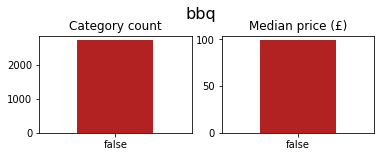

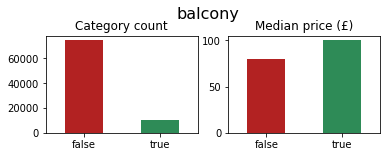

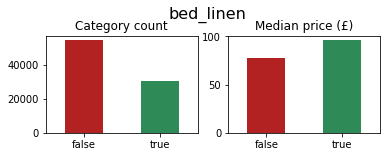

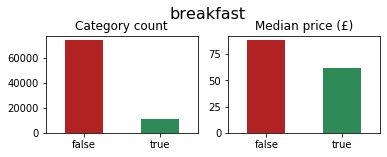

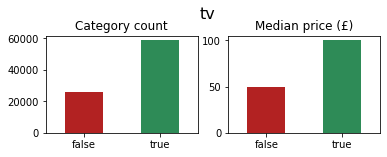

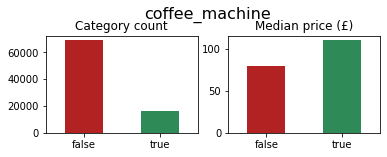

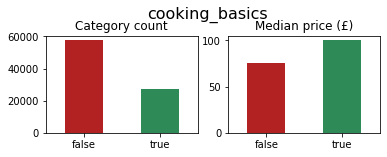

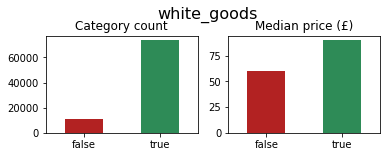

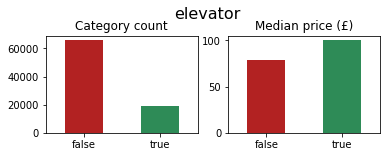

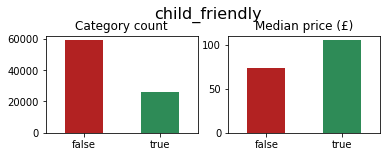

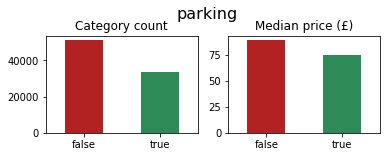

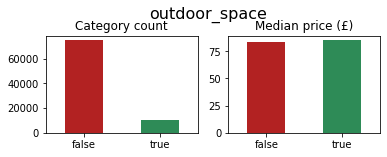

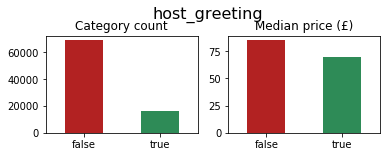

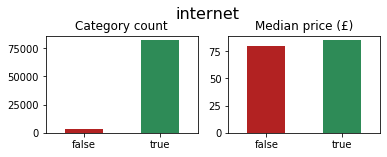

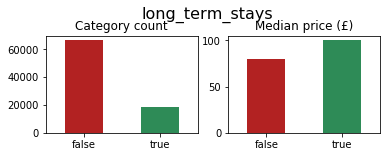

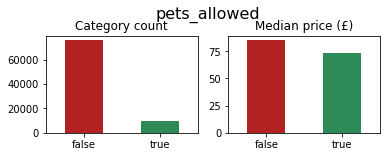

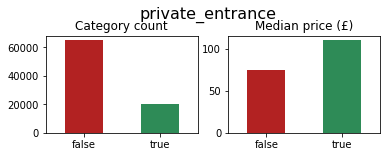

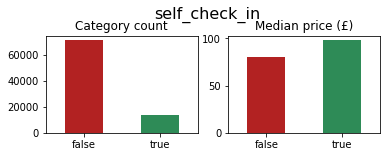

In [98]:
for col in df.iloc[:,31:-2].columns:
    binary_count_and_price_plot(col, figsize=(6,2))

# Preparing the data for modeling

**Dropping columns and assessing multi-collinearity**

Categorical variables will now be one-hot encoded:

In [0]:
transformed_df = pd.get_dummies(df)
# transformed_df.to_csv('/content/drive/My Drive/data/london_transformed.csv')

The dataset can now be assessed for multi-collinearity.

In [0]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

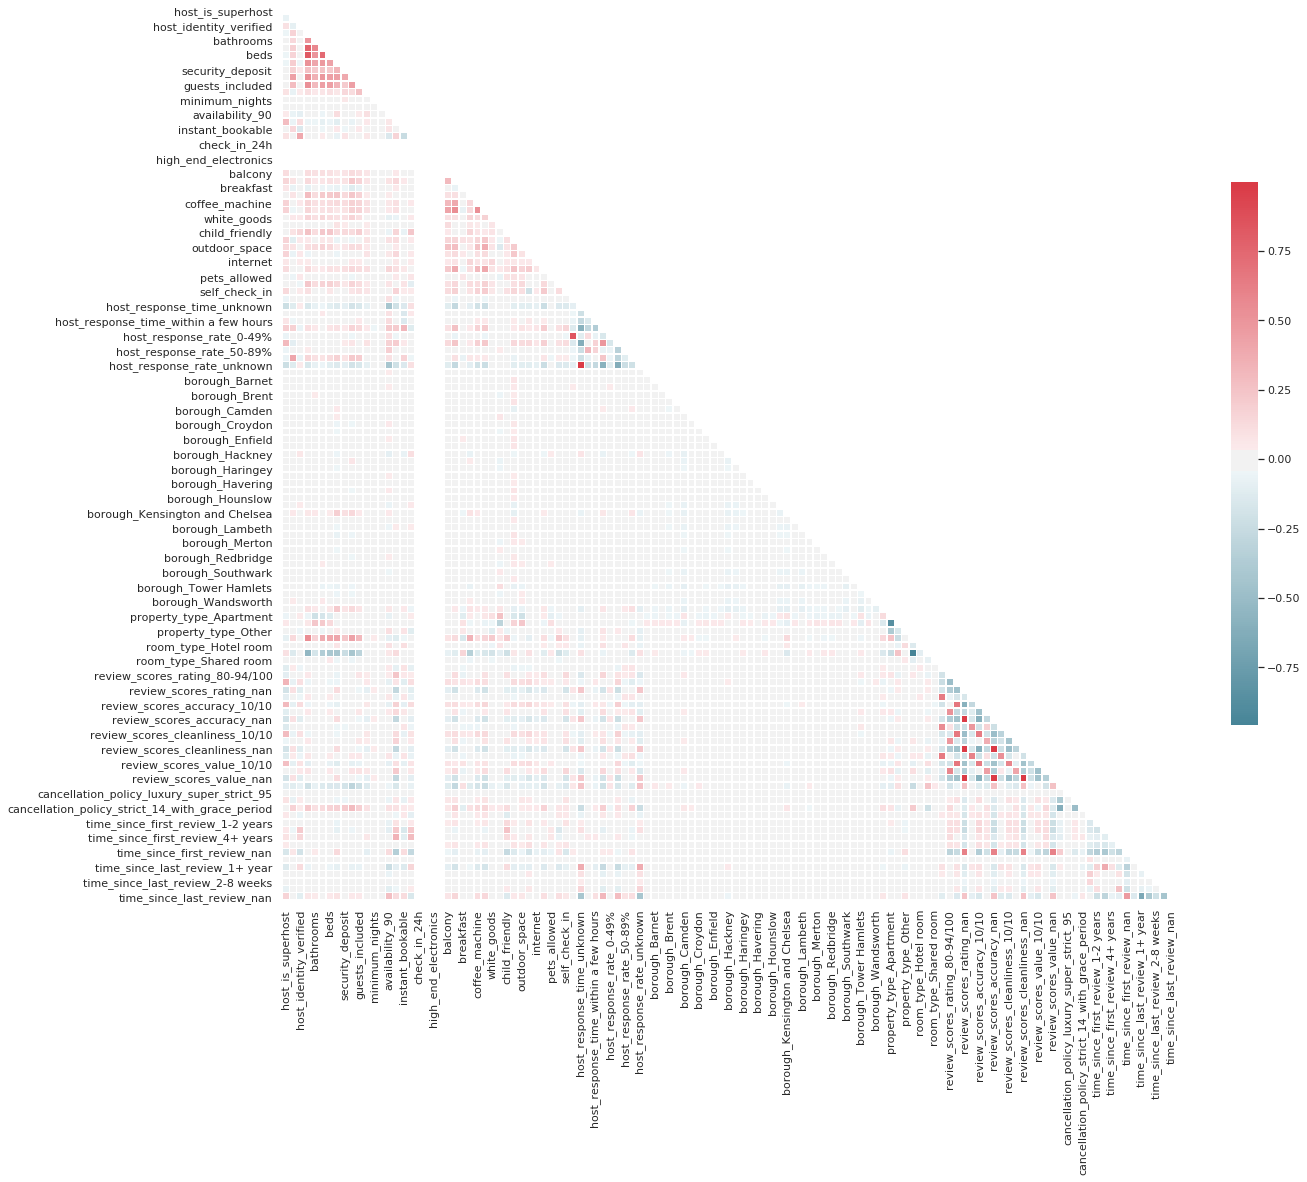

In [184]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

It doesn't look like there are any significant collinear relationships with boroughs, so these will temporarily be dropped to produce a clearer heatmap for the remaining features:

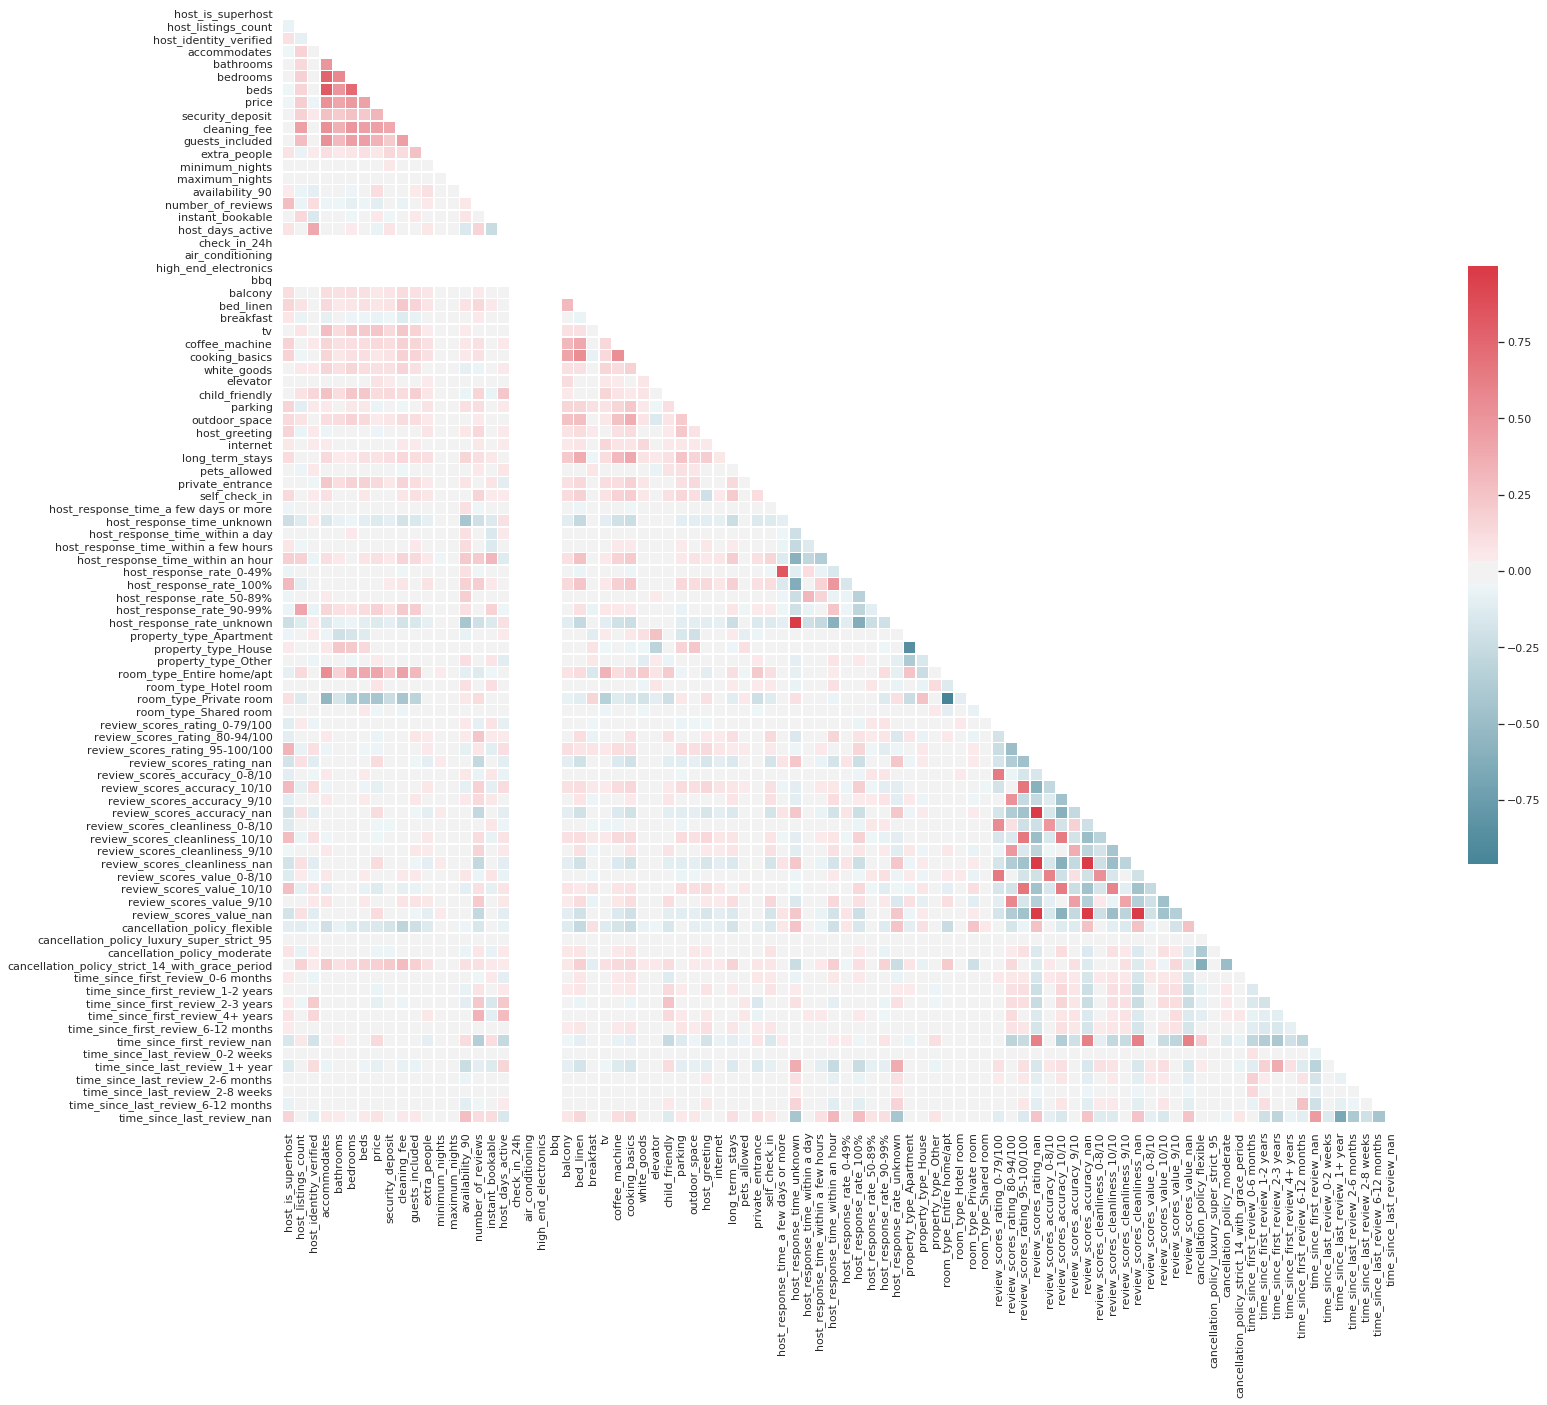

In [185]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('borough')]), axis=1), figsize=(25,22))

Areas of multi-collinearity:

- Beds, bedrooms, guests included and the number of people that a property accommodates are highly correlated. The number of people accommodated has traditionally been a more high priority search parameter on Airbnb, as it is more relevant for private and shared rooms than the number of bedrooms (and is still the second highest priority parameter when searching on the site, after dates (when read from left to right on the search page)).
- Unsurprisingly, there are perfect correlations between NaN reviews (i.e. listings that are not reviewed yet) for different review categories, and first and last review times. NaN categories can therefore be dropped.
- The same is true of unknown host response rates and times. One of these (rate) will be dropped.
- There is a correlation between a 0-49% response rate, and an average response time of a few days or more. One of these (rate) will be dropped.
- There are strong negative correlations between houses and apartments, and between private rooms and entire homes (as these were the main two categories of their features before they were one-hot encoded). Although these are important categories, one of each will be dropped in order to reduce multi-collinearity (apartments and private rooms, as these are the second most common categories).

In [0]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)


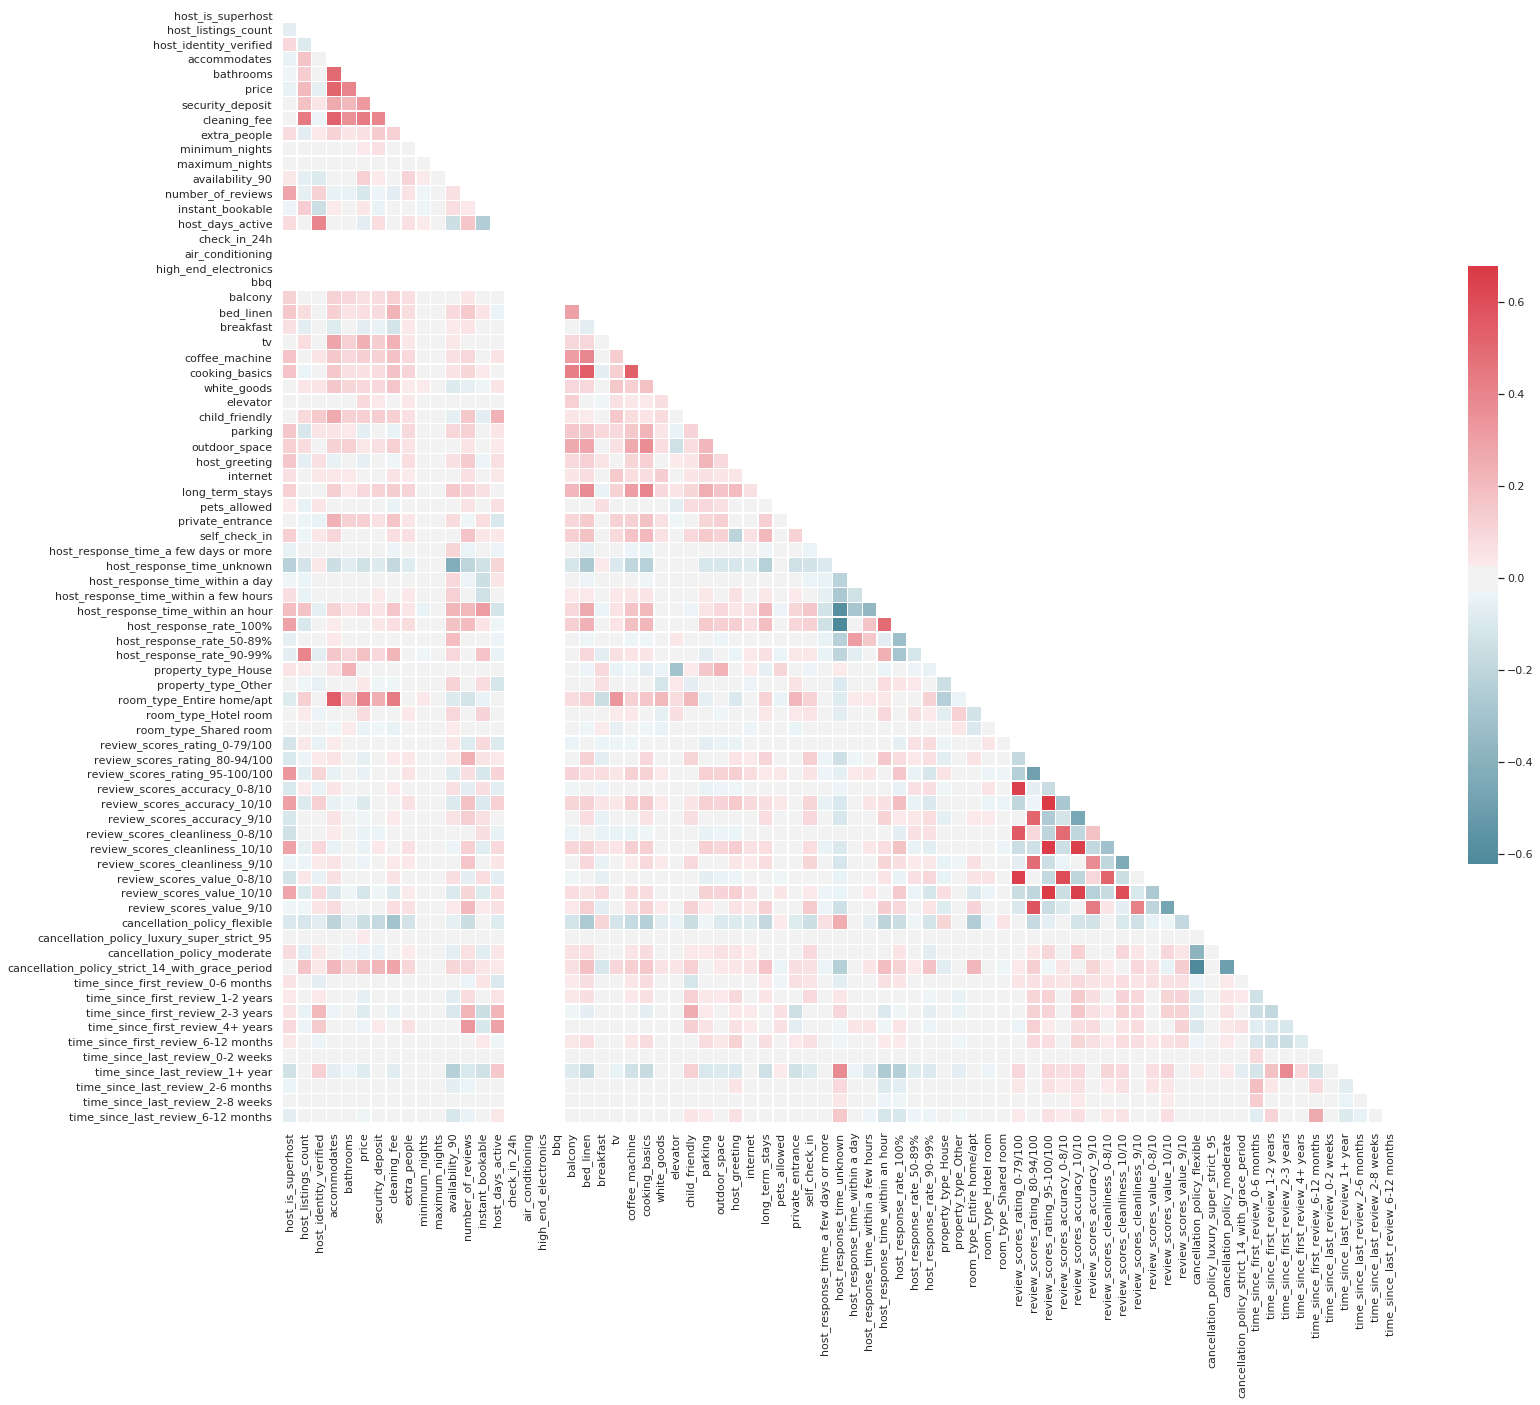

In [187]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('borough')]), axis=1), figsize=(25,22))

There are still some fairly strong correlations between highly rated properties of different reviews categories - i.e. if a property gets a 10/10 for one category, it is likely to get a 10/10 for other categories. However, these will be left in for now and can be experimented with later to see if removing them improves the model.

**Standardising and normalising**

Other than availability_90 and host_days_active, the remaining numerical features are all postively skewed and could benefit from log transformation.

In [0]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'cleaning_fee', 'extra_people', 'host_days_active', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit']

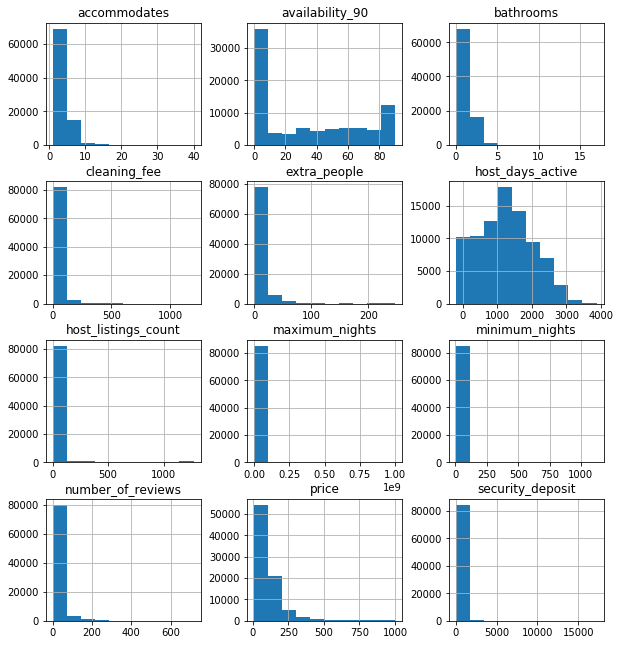

In [200]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [0]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

This appears to have helped some of the distributions, although some (e.g. cleaning fee, extra people fee and security fee) contain a large number of 0s, which means these features are not normally distributed. Most importantly, however, the target variable price now appears much more normally distributed.

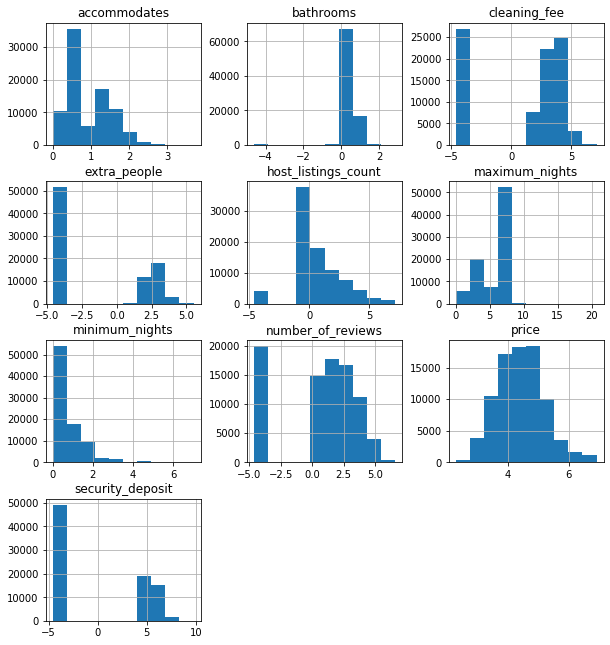

In [202]:
transformed_df[numerical_columns].hist(figsize=(10,11));

Finally, the predictive features X and the target feature y can be separated, and X will be scaled. StandardScaler from sklearn will be used, but the type of scaling used could be experimented with later to see if alternative versions yield better results.

In [0]:
# transformed_df.drop(['high_end_electronics','bbq','air_conditioning','check_in_24h'], axis=1, inplace=True)


In [203]:
transformed_df['air_conditioning'].loc[transformed_df['air_conditioning'].isna()]=0
transformed_df['high_end_electronics'].loc[transformed_df['high_end_electronics'].isna()]=0
transformed_df['high_end_electronics'].loc[transformed_df['high_end_electronics'].isna()]=0
transformed_df['bbq'].loc[transformed_df['bbq'].isna()]=0
transformed_df['check_in_24h'].loc[transformed_df['check_in_24h'].isna()]=0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
# Separating X and y
# df=df.dropna()

X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

***

# Building a neural network

In this section several machine learning and deep learning models will be built in order to predict an Airbnb listing's price.

The evaluation metrics used will be mean squared error (for loss) and r squared (for accuracy).

In [0]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Model 1: XGBoost

Before building a neural network, a vanilla XGBoost model will be used to predict price, in order to provide a baseline level of accuracy and a measure of feature importance. This most likely provides the best achievable accuracy using machine learning models (other than possible small accuracy increases from hyper-parameter tuning) due to XGBoost's superior performance.

In [206]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:34:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.3 minutes

Training MSE: 0.164
Validation MSE: 0.1637

Training r2: 0.7281
Validation r2: 0.7237


In [208]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
host_is_superhost,0.000000
borough_Wandsworth,0.000000
borough_Tower Hamlets,0.000000
borough_Sutton,0.000000
borough_Richmond upon Thames,0.000000
...,...
accommodates,0.022810
bedrooms,0.024767
bathrooms,0.041064
room_type_Entire home/apt,0.282643


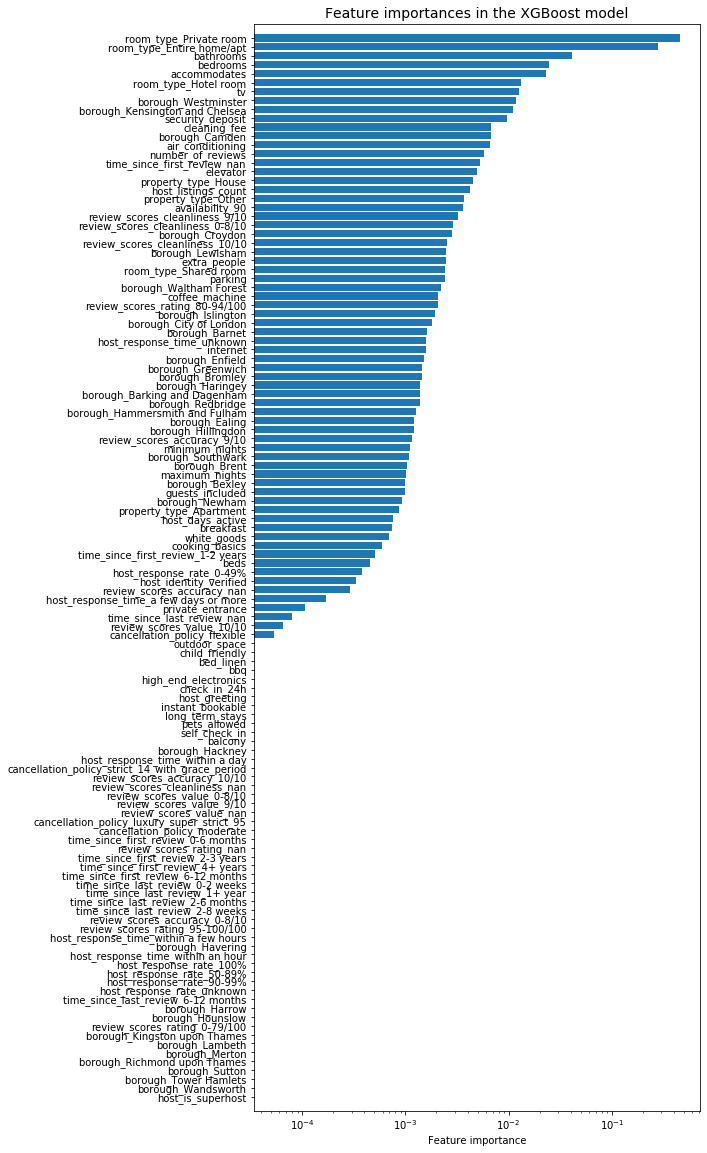

In [210]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.xscale('log')
plt.show()

About a third of features have a feature importance of 0 in this XGBoost regression model, and could potentially be removed (although they will not be for the deep learning modeling part of this project, as they may have interactions with other features).

**The top 10 most important features are:**
- How many people the property accommodates
- The cleaning fee
- How many other listings the host has (and whether they are a multi-listing host)
- How many days are available to book out of the next 90
- The fee per extra person
- The number of reviews
- The number of bathrooms
- The security deposit
- If the property is in Westminster
- The minimum nights stay

It is not surprising that the most important feature is how many people the property accommodates, as that's one of the main things you would use to search for properties with in the first place. It is also not surprising that features related to location and reviews are in the top ten.

It is perhaps more surprising that **the third most important feature is related to how many other listings the host manages on Airbnb, rather than the listing itself**. However, this does not mean that a host that manages more properties will result in a listing gaining higher prices. Firstly, the data appears to be somewhat skewed by a few very large property managers. Secondly, the relationship is with the advertised prices set, rather than actual prices achieved, suggesting that if anything more experienced hosts tend to set (rather than necessarily achieve) higher prices. And thirdly, we cannot necessarily imply a causative relationship - it could be that more experienced multi-listing hosts (especially Airbnb property management companies) tend to take on more expensive properties (which is indeed the case for some, e.g. One Fine Stay).

It is also notable that **three other fee types - cleaning, security and extra people - all make the top 10 feature list**. It is likely that these are positive relationships, and that when a host sets a higher price for the nightly stay they are also likely to set other prices high.

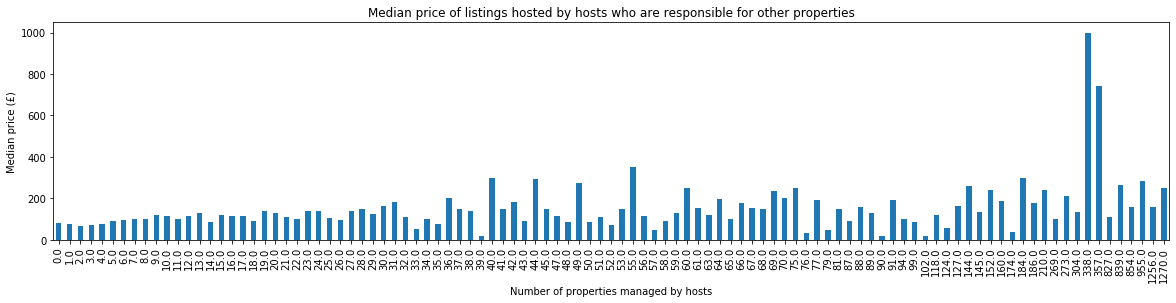

In [211]:
# Median price for different host listing counts
plt.figure()
df.groupby('host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price (£)');

### Model 2: three layer neural network

For the initial version of the neural network, a relatively shallow three layer NN will be created. It will consist of densely-connected layers, and use a relu activation function for the hidden layers and a linear activation function for the output layer, as it is being used for a regression task. The loss function will be mean squared error (again, because this is for regression).





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               15488     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 114,561
Trainable params: 114,561
Non-trainable params: 0
_________________________________________________________________
None


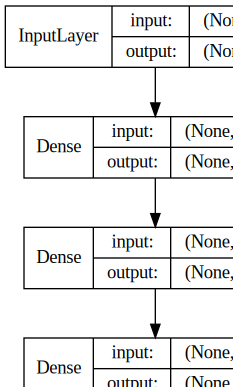

In [212]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [221]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.10)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

Train on 61239 samples, validate on 6805 samples
Epoch 1/100
61239/61239 [==============================] - 2s 39us/step - loss: 0.0857 - mean_squared_error: 0.0857 - val_loss: 0.1245 - val_mean_squared_error: 0.1245
Epoch 2/100
61239/61239 [==============================] - 2s 39us/step - loss: 0.0783 - mean_squared_error: 0.0783 - val_loss: 0.1307 - val_mean_squared_error: 0.1307
Epoch 3/100
61239/61239 [==============================] - 2s 39us/step - loss: 0.0738 - mean_squared_error: 0.0738 - val_loss: 0.1321 - val_mean_squared_error: 0.1321
Epoch 4/100
61239/61239 [==============================] - 2s 40us/step - loss: 0.0714 - mean_squared_error: 0.0714 - val_loss: 0.1363 - val_mean_squared_error: 0.1363
Epoch 5/100
61239/61239 [==============================] - 2s 37us/step - loss: 0.0716 - mean_squared_error: 0.0716 - val_loss: 0.1416 - val_mean_squared_error: 0.1416
Epoch 6/100
61239/61239 [==============================] - 2s 38us/step - loss: 0.0672 - mean_squared_error: 0.

In [0]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Training MSE: 0.0304
Validation MSE: 0.2168

Training r2: 0.9496
Validation r2: 0.634


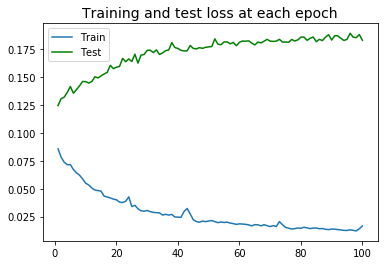

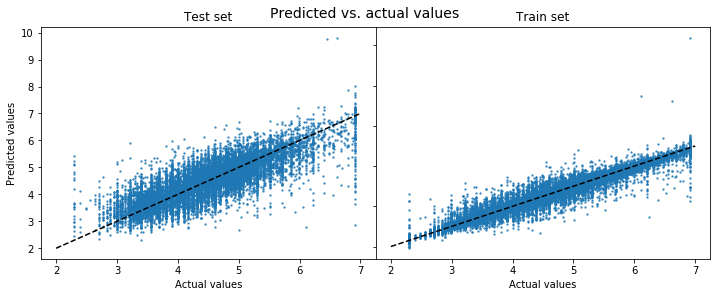

In [222]:
nn_model_evaluation(nn2)

Compared to the XGBoost model the neural network has performed worse. However, the training set had much better results in the neural network, indicating that overfitting is an issue.

The line graph above highlights this point, showing the disparity between the train and test set MSE at each epoch. The scatterplot above further highlights this point, demonstrating that the values cluster more closely to a line form for the training set.

Further iterations on the model will attempt to reduce overfitting.

### Model 3: four-layer neural network with L1 regularization and more epochs

To try and reduce over-fitting, L1 regularization will be used. This acts to reduce parameter coefficients (or potentially remove them altogether by setting the coefficient to zero) in order to to reduce model complexity and overfitting. Unlike L2 regularization, L1 regularization performs penalised estimation and selection simultaneously, and so is preferred when the number of predictors is very high.

An extra layer will also be added, to see whether it is able to increase model accuracy (r2).

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               15488     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 246,401
Trainable params: 246,401
Non-trainable params: 0
_________________________________________________________________
None


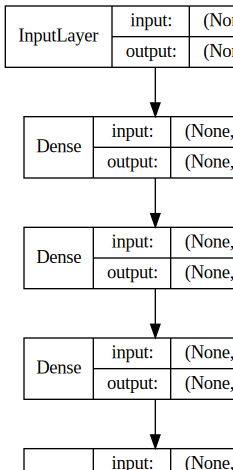

In [223]:
# Building the model
nn3 = models.Sequential()
nn3.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

# Visualising the neural network
SVG(model_to_dot(nn3, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [224]:
# Training the model
nn3_start = time.time()

nn3_history = nn3.fit(X_train,
                  y_train,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn3_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")

Train on 61239 samples, validate on 6805 samples
Epoch 1/150
61239/61239 [==============================] - 4s 72us/step - loss: 26.4751 - mean_squared_error: 0.6838 - val_loss: 8.4145 - val_mean_squared_error: 0.1920
Epoch 2/150
61239/61239 [==============================] - 4s 65us/step - loss: 4.6133 - mean_squared_error: 0.2145 - val_loss: 2.3688 - val_mean_squared_error: 0.1934
Epoch 3/150
61239/61239 [==============================] - 4s 66us/step - loss: 1.5449 - mean_squared_error: 0.1917 - val_loss: 0.9848 - val_mean_squared_error: 0.1831
Epoch 4/150
61239/61239 [==============================] - 4s 68us/step - loss: 0.7378 - mean_squared_error: 0.1818 - val_loss: 0.5750 - val_mean_squared_error: 0.1815
Epoch 5/150
61239/61239 [==============================] - 7s 119us/step - loss: 0.4925 - mean_squared_error: 0.1791 - val_loss: 0.4402 - val_mean_squared_error: 0.1785
Epoch 6/150
61239/61239 [==============================] - 4s 71us/step - loss: 0.4140 - mean_squared_error: 

Training MSE: 0.174
Validation MSE: 0.1709

Training r2: 0.7115
Validation r2: 0.7115


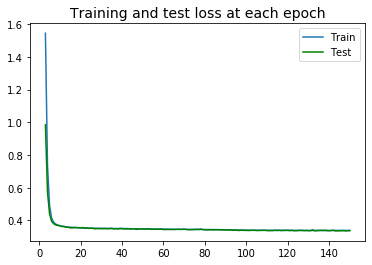

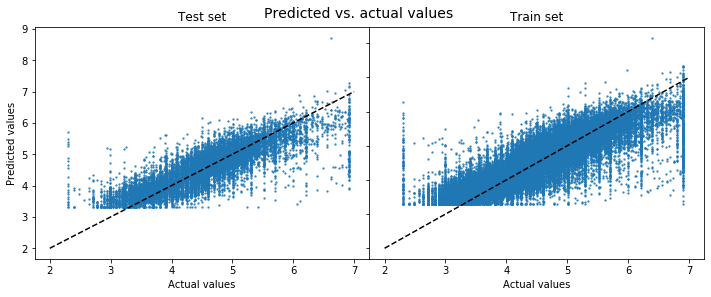

In [225]:
# Evaluating the model
nn_model_evaluation(nn3, skip_epochs=2)

This NN has performed better than the previous model, and about as well as the XGBoost model. It has also removed the overfitting issue, as train and test sets are performing the same. However, for some reason y values less than 3 are not being predicted.

Now that bias has been reduced, further iterations will attempt to increase accuracy.

### Model 4: neural network with SGD optimizer

This NN is mostly the same as model 3, but uses an SGD (stochastic gradient descent) optimizer instead of Adam.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 128)               14976     
_________________________________________________________________
dense_19 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_20 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_21 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 513       
Total params: 245,889
Trainable params: 245,889
Non-trainable params: 0
_________________________________________________________________
None


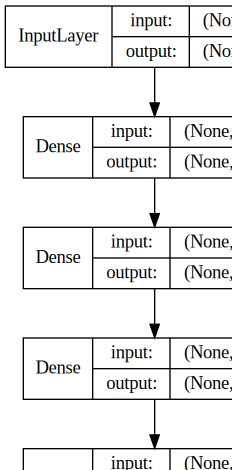

In [178]:
# Building the model
nn4 = models.Sequential()
nn4.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='SGD',
            metrics=['mean_squared_error'])

# Model summary
print(nn4.summary())

# Visualising the neural network
SVG(model_to_dot(nn4, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [179]:
# Training the model
nn4_start = time.time()

nn4_history = nn4.fit(X_train,
                  y_train,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn4_end = time.time()

print(f"Time taken to run: {round((nn4_end - nn4_start)/60,1)} minutes")

Train on 61239 samples, validate on 6805 samples
Epoch 1/150
61239/61239 [==============================] - 8s 136us/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 2/150
61239/61239 [==============================] - 8s 132us/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 3/150
61239/61239 [==============================] - 8s 131us/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 4/150
61239/61239 [==============================] - 8s 130us/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 5/150
61239/61239 [==============================] - 8s 132us/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 6/150
61239/61239 [==============================] - 8s 132us/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 7/1

KeyboardInterrupt: ignored

In [0]:
nn_model_evaluation(nn4, skip_epochs=10) # This model took several epochs before the loss was in a similar range to other models

The SGD optimizer performs slightly worse than the Adam optimizer. Also, y values less than 3 are still not being predicted.

### Model 5: neural network with dropout regularization at 50%

This model will be similar to Model 3, but will use dropout regularization instead. A dropout rate of 50% will be used. The number of epochs will be reduced to 50 as it does not seem to take as many as 150 epochs to reach optimum loss minimisation.

In [0]:
# Building the model
nn5 = models.Sequential()
nn5.add(layers.Dropout(0.5, input_shape=(X_train.shape[1],)))
nn5.add(layers.Dense(128, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(256, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(512, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn5.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn5.summary())

# Visualising the neural network
SVG(model_to_dot(nn5, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# Training the model
nn5_start = time.time()

nn5_history = nn5.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=256,
                  validation_split = 0.1)

nn5_end = time.time()

print(f"Time taken to run: {round((nn5_end - nn5_start)/60,1)} minutes")

In [0]:
nn_model_evaluation(nn5, skip_epochs=2)

Using dropout validation has reduced the model performance substantially compared to L1 regularization.

### Model 6: neural network with dropout regularization at 30% and a larger batch size

In order to confirm that dropout regularization is not the solution, it will be tried again using a lower dropout rate (30%), and the batch size will be increased.

In [0]:
# Building the model
nn6 = models.Sequential()
nn6.add(layers.Dropout(0.2, input_shape=(X_train.shape[1],)))
nn6.add(layers.Dense(128, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(256, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(512, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn6.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn6.summary())

# Visualising the neural network
SVG(model_to_dot(nn6, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# Training the model
nn6_start = time.time()

nn6_history = nn6.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=512,
                  validation_split = 0.1)

nn6_end = time.time()

print(f"Time taken to run: {round((nn6_end - nn6_start)/60,1)} minutes")

In [0]:
nn_model_evaluation(nn6)

Although reducing the dropout rate has improved performance compared to the previous model, it is still not as good as using L1 regularization.

### Model 7: removing excess review rating features

So far, a number of hyperparameters have been tuned in order to increase the performance of the NN. Adding extra layers can often increase the performance of a NN, at the cost of increasing computational requirements. Before experimenting further with additional layers, it is worth going back to consider whether the best possible features are being included.

In the 'Preparing the data for modeling' section above, it was noted that a lot of the review columns are reasonably highly correlated with each other. They were left in to see whether they would be useful after all. However, the feature importances graph produced by the XGBoost model suggest that they were of relatively low importance.

This model will drop review columns other than the overall review rating, and use the same NN structure as Model 3, in order to see whether this produces a better model.

Columns will be dropped from the existing X_train and X_test split, for consistency.

In [0]:
all_review = list(X_train.columns[X_train.columns.str.startswith("review_scores")])
review_to_keep = list(X_train.columns[X_train.columns.str.startswith("review_scores_rating")])
review_to_drop = [x for x in all_review if x not in review_to_keep]

X_train_short = X_train.drop(review_to_drop, axis=1)
X_test_short = X_test.drop(review_to_drop, axis=1)

In [0]:
# Building the model
nn7 = models.Sequential()
nn7.add(layers.Dense(128, input_shape=(X_train_short.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn7.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn7.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn7.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn7.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn7.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn7.summary())

# Visualising the neural network
SVG(model_to_dot(nn7, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# Training the model
nn7_start = time.time()

nn7_history = nn7.fit(X_train_short,
                  y_train,
                  epochs=50,
                  batch_size=256,
                  validation_split=0.1)

nn7_end = time.time()

print(f"Time taken to run: {round((nn7_end - nn7_start)/60,1)} minutes")

In [0]:
nn_model_evaluation(nn7, skip_epochs=2, X_train=X_train_short, X_test=X_test_short)

The model with the additional review columns removed performs almost exactly the same as the best previous NN (Model 3). Therefore, because it is able to achieve the same performance with 18 fewer columns, it is the preferred model when choosing which model to put into production as it would require less data and be less computationally expensive.

### Model 8: using latitude and longitude instead of boroughs

The final part of feature engineering to experiment with is to investigate whether using latitude and longitude to represent location might increase performance compared to using borough. To do so, the borough features will be dropped (in addition to the review columns that were already dropped), and latitude and longitude will be added back in and transformed using the same scaler as the rest of the data.

In [0]:
# Joining the transformed_df (pre-scaling) and the lat_long dataframe, after dropping excess review features
df_lat_long = transformed_df.drop(review_to_drop, axis=1).join(lat_long)

# Dropping borough columns
borough_to_drop = list(df_lat_long.columns[df_lat_long.columns.str.startswith("borough")])
df_lat_long = df_lat_long.drop(borough_to_drop, axis=1)

# Separating X and y
X_lat_long = df_lat_long.drop('price', axis=1)
y_lat_long = df_lat_long.price

# Scaling
scaler = StandardScaler()
X_lat_long = pd.DataFrame(scaler.fit_transform(X_lat_long), columns=list(X_lat_long.columns))

# Splitting into train and test sets
X_train_lat_long, X_test_lat_long, y_train_lat_long, y_test_lat_long = train_test_split(X_lat_long, y_lat_long, test_size=0.2, random_state=123)

In [0]:
# Building the model
nn8 = models.Sequential()
nn8.add(layers.Dense(128, input_shape=(X_train_lat_long.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn8.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn8.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn8.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn8.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn8.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn8.summary())

# Visualising the neural network
SVG(model_to_dot(nn8, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# Training the model
nn8_start = time.time()

nn8_history = nn8.fit(X_train_lat_long,
                  y_train_lat_long,
                  epochs=80,
                  batch_size=256,
                  validation_split=0.1)

nn8_end = time.time()

print(f"Time taken to run: {round((nn8_end - nn8_start)/60,1)} minutes")

In [0]:
nn_model_evaluation(nn8, X_train=X_train_lat_long, X_test=X_test_lat_long, y_train=y_train_lat_long, y_test=y_test_lat_long)

Using latitude and longitude performs worse than using borough for location.

### Model 9: five-layer neural network with a min-max scaler

Model 3 is still the best model. As a final attempt to improve its performance, an alternative scaling method will be used (min-max scaling to a range of 0-1) and an additional layer will be added.

In [0]:
# Dropping review columns from the original dataframe (after log transformation)
df_minmax = transformed_df.drop(review_to_drop, axis=1)

# Separating X and y
X_minmax = df_minmax.drop('price', axis=1)
y_minmax = df_minmax.price

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
X_minmax = pd.DataFrame(scaler.fit_transform(X_minmax), columns=list(X_minmax.columns))

# Splitting into train and test sets
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(X_minmax, y_minmax, test_size=0.2, random_state=123)

In [0]:
# Building the model
nn9 = models.Sequential()
nn9.add(layers.Dense(128, input_shape=(X_train_minmax.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn9.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn9.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn9.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn9.add(layers.Dense(1024, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn9.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn9.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn9.summary())

# Visualising the neural network
SVG(model_to_dot(nn9, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# Training the model
nn9_start = time.time()

nn9_history = nn9.fit(X_train_minmax,
                  y_train_minmax,
                  epochs=80,
                  batch_size=256,
                  validation_split = 0.1)

nn9_end = time.time()

print(f"Time taken to run: {round((nn9_end - nn9_start)/60,1)} minutes")

In [0]:
nn_model_evaluation(nn9, skip_epochs=4, X_train=X_train_minmax, X_test=X_test_minmax, y_train=y_train_minmax, y_test=y_test_minmax)

The five-layer NN performs worse than the previous best-scoring NN (Model 7).

### Final model selection

Overall, the XGBoost model (Model 1) is the preferred model, which performs ever so slightly better than the best neural network (Model 7) and is less computationally expensive. It could possibly be improved further with hyper-parameter tuning.

***

# Conclusions and recommendations

This is one of those situations where deep learning simply isn't necessary for prediction, and a machine learning model performs just as well.
However, even in the best performing model, the model was only able to explain 73% of the variation in price. The remaining 27% is probably made up of features that were not present in the data. It is likely that a significant proportion of this unexplained variance is due to variations in the listing photos. The photos of properties on Airbnb are very important in encouraging guests to book, and so can also be expected to have a significant impact on price - better photos (primarily better quality properties and furnishings, but also better quality photography) equal higher prices.

**Potential directions for future work**
- Find a way to incorporate image quality into the model, e.g. by using the output of a convolutional neural network to assess image quality as an input into the pricing model 
- Use better quality/more accurate data which includes the actual average prices paid per night
- Include a wider geographic area, e.g. the rest of the UK or other major cities around the world
- Augment the model with natural language processing (NLP) of listing descriptions and/or reviews, e.g. for sentiment analysis or looking for keywords
- In addition to predicting base prices, a sequence model could be created to calculate daily rates using data on seasonality and occupancy, which would allow the creation of actual pricing software
- Tailor the model more specifically to new listings in order to help hosts set prices for new properties, by removing features that would not be known at the time - e.g. other fees, availability and reviews

In [180]:
transformed_df

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,instant_bookable,host_days_active,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,outdoor_space,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,self_check_in,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,...,borough_Westminster,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_scores_rating_0-79/100,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_rating_nan,review_scores_accuracy_0-8/10,review_scores_accuracy_10/10,review_scores_accuracy_9/10,review_scores_accuracy_nan,review_scores_cleanliness_0-8/10,review_scores_cleanliness_10/10,review_scores_cleanliness_9/10,review_scores_cleanliness_nan,review_scores_value_0-8/10,review_scores_value_10/10,review_scores_value_9/10,review_scores_value_nan,cancellation_policy_flexible,cancellation_policy_luxury_super_strict_95,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_first_review_nan,time_since_last_review_0-2 weeks,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months,time_since_last_review_nan
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11551,1.0,3.0,1.0,4,1.0,1.0,1.0,88,400,30,2,20,3,180,61,185,1,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
38151,0.0,1.0,0.0,2,1.0,1.0,1.0,65,0,0,1,0,1,730,90,0,0,3194.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
13913,0.0,4.0,0.0,2,1.0,1.0,0.0,65,100,15,1,15,1,29,90,19,0,3431.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
38407,0.0,1.0,0.0,2,1.0,1.0,1.0,79,0,0,2,0,2,365,0,137,1,3193.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
90700,0.0,2.0,0.0,2,1.0,1.0,1.0,105,0,35,2,10,2,1125,24,339,1,2924.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39868875,0.0,1.0,0.0,2,1.0,1.0,1.0,70,200,30,1,0,3,30,62,0,1,1840.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
39869123,0.0,1.0,0.0,2,1.0,1.0,2.0,69,200,25,1,0,2,1125,23,0,0,1673.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
39869214,0.0,18.0,0.0,4,1.0,1.0,2.0,90,0,55,1,0,3,1125,63,0,1,11.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0,